<h1> Project summary</h1>

This analysis involves research of more than 38 000 used cars advertised at a car bazaar. It includes <b>comprehensive EDA</b> and implementations of very robust Linear Regressions & Histogram Gradient Booster with <b>R squared and adjusted R squared of 0.926 and 0.92</b> containing key assumptions of linear regression checking. This may bring a <b>very strong business implementation</b> as well as a <b>really solid use-case for an average person</b>. 

The dependent variable was the price of the car in US dollars and the columns included features such as engine capacity, color or year of production of the car. Among the independent variables were also Boolean features with names feature_0 - feature_9, which were not explained and therefore had to be analysed accordingly. 

<h1> Project outline</h1>
    
    • State the initial hypotheses and assumptions, decide for an approach 
    • Make necessary imports, take first look at the dataset
    • Decide how to clean the dataset and engineer some of the missing values
    • Analyse the individual distribution of some of the features
    • Research the relations of properties of the car and price
    • Dive into social analysis - upvotes, duration listed, number of photos and how these relate to price
    • Analysis of features feature_0 - feature_9
    • Correlation inspection
    • Predictive modeling
        • Linear Regression - check of 4 key assumptions, feature selection
        • Histogram Gradient Boosting

<h2>Hypotheses and notes</h2>

    • There will be manufacturers with strong correlation with price (luxurious brands such as Porsche)
    • Odometer value and year of production will be negatively correlated and might be in (anti)correlation with price
    • State of the car will have strong impact on the car
    • Some engine fuel types may be in general higher priced than others, same goes for drivetrain types
    • Location of the market will not be impactful
    • The presence of all features feature_0 - feature_9 will have positive impact on price
    • Duration listed may be in positive correlation with price (long lasting offers may be overpriced)
    
    • Note: The whole project could be approached from a completely different perspective, for instance analysis of car 
            brand/model x location, body types, engine fuels etc.

<h2>Key assumptions made after some initial steps</h2>

    • The dataset presents the initial price of the offer - this may be strongly confusing when the seller overprices it
        • We have assumed that this would usually happen in correlation with outlier duration of listing
    • The availability of exchange does not affect the price
    • Offers with price of 1 USD are "fake ones" made just to bring attention
    • There is some correlation between horsepower of a car and it’s engine capacity
    • In order to make the duration listed variable meaningful, we have decided to assume that all offers are closed

In [2]:
# https://www.kaggle.com/lepchenkov/usedcarscatalog

<h2> Necessary imports, first look at the dataset</h2>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

pd.set_option("max_columns", 35)
sb.set_style("whitegrid", {"grid.color": ".78"})
sb.set(palette="deep")
cmap = sb.diverging_palette(240, 25, as_cmap=True)

In [4]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm

In [5]:
df = pd.read_csv("cars.csv")

In [6]:
# Will be dropped: is_exchangeable, engine_has_gas, engine_type
    # We assumed that is_exchangeable would not have any impact on the price 
        # It could, however, affect the duration_listed
    # engine_has_gas column is directly related to "gas" in engine_fuel column, which preserves way more information
    # Same goes for engine_type column, whose entries directly result from the feature in engine_fuel, 
    # which preserves way more information
# Candidates to be dropped if not impactful: location_region
df.drop(columns=["is_exchangeable", "engine_has_gas", "engine_type"], inplace=True)

# Moving the dependent variable to the last column
df.insert(len(df.columns)-1, "price_usd", df.pop("price_usd")) 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38531 entries, 0 to 38530
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   manufacturer_name  38531 non-null  object 
 1   model_name         38531 non-null  object 
 2   transmission       38531 non-null  object 
 3   color              38531 non-null  object 
 4   odometer_value     38531 non-null  int64  
 5   year_produced      38531 non-null  int64  
 6   engine_fuel        38531 non-null  object 
 7   engine_capacity    38521 non-null  float64
 8   body_type          38531 non-null  object 
 9   has_warranty       38531 non-null  bool   
 10  state              38531 non-null  object 
 11  drivetrain         38531 non-null  object 
 12  location_region    38531 non-null  object 
 13  number_of_photos   38531 non-null  int64  
 14  up_counter         38531 non-null  int64  
 15  feature_0          38531 non-null  bool   
 16  feature_1          385

In [8]:
# Rename the boolean variables from True/False to 1/0
df.replace({True: 1, False: 0}, inplace=True)

# All market names end with the word "обл.", therefore this word can be stripped for convenience
lst = [name for name in df["location_region"].unique()]
for name in lst:
    df["location_region"].replace({name: name.split()[0]}, inplace=True)

In [9]:
df.head()

manufacturer_name model_name transmission   color  odometer_value  \
0            Subaru    Outback    automatic  silver          190000   
1            Subaru    Outback    automatic    blue          290000   
2            Subaru   Forester    automatic     red          402000   
3            Subaru    Impreza   mechanical    blue           10000   
4            Subaru     Legacy    automatic   black          280000   

   year_produced engine_fuel  engine_capacity  body_type  has_warranty  state  \
0           2010    gasoline              2.5  universal             0  owned   
1           2002    gasoline              3.0  universal             0  owned   
2           2001    gasoline              2.5        suv             0  owned   
3           1999    gasoline              3.0      sedan             0  owned   
4           2001    gasoline              2.5  universal             0  owned   

  drivetrain location_region  number_of_photos  up_counter  feature_0  \
0        all         Минская                 9          13          0   
1        all         Минская                12          54          0   
2        all         Минская                 4          72          0   
3        all         Минская                 9          42          1   
4        all      Гомельская                14           7          0   

   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0          1          1          1          0          1          0   
1          1          0          0          1          1          0   
2          1          0          0          0          0          0   
3          0          0          0          0          0          0   
4          1          0          1          1          0          0   

   feature_7  feature_8  feature_9  duration_listed  price_usd  
0          1          1          1               16   10900.00  
1          0          0          1               83    5000.00  
2          0          1          1              151    2800.00  
3          0          0          0               86    9999.00  
4          0          0          1                7    2134.11

In [10]:
#Check the numeric variables, check for outliers, check mean and median, max and min values
pd.concat([df.describe().T, df.median().rename("median")], axis=1).T

odometer_value  year_produced  engine_capacity  has_warranty  \
count     38531.000000   38531.000000     38521.000000  38531.000000   
mean     248864.638447    2002.943734         2.055161      0.011653   
std      136072.376530       8.065731         0.671178      0.107319   
min           0.000000    1942.000000         0.200000      0.000000   
25%      158000.000000    1998.000000         1.600000      0.000000   
50%      250000.000000    2003.000000         2.000000      0.000000   
75%      325000.000000    2009.000000         2.300000      0.000000   
max     1000000.000000    2019.000000         8.000000      1.000000   
median   250000.000000    2003.000000         2.000000      0.000000   

        number_of_photos    up_counter     feature_0     feature_1  \
count       38531.000000  38531.000000  38531.000000  38531.000000   
mean            9.649062     16.306091      0.228543      0.607199   
std             6.093217     43.286933      0.419900      0.488379   
min             1.000000      1.000000      0.000000      0.000000   
25%             5.000000      2.000000      0.000000      0.000000   
50%             8.000000      5.000000      0.000000      1.000000   
75%            12.000000     16.000000      0.000000      1.000000   
max            86.000000   1861.000000      1.000000      1.000000   
median          8.000000      5.000000      0.000000      1.000000   

           feature_2     feature_3     feature_4     feature_5     feature_6  \
count   38531.000000  38531.000000  38531.000000  38531.000000  38531.000000   
mean        0.223820      0.275804      0.241468      0.356077      0.170979   
std         0.416808      0.446924      0.427979      0.478845      0.376496   
min         0.000000      0.000000      0.000000      0.000000      0.000000   
25%         0.000000      0.000000      0.000000      0.000000      0.000000   
50%         0.000000      0.000000      0.000000      0.000000      0.000000   
75%         0.000000      1.000000      0.000000      1.000000      0.000000   
max         1.000000      1.000000      1.000000      1.000000      1.000000   
median      0.000000      0.000000      0.000000      0.000000      0.000000   

           feature_7     feature_8     feature_9  duration_listed  \
count   38531.000000  38531.000000  38531.000000     38531.000000   
mean        0.263736      0.415328      0.579404        80.577249   
std         0.440663      0.492785      0.493661       112.826569   
min         0.000000      0.000000      0.000000         0.000000   
25%         0.000000      0.000000      0.000000        23.000000   
50%         0.000000      0.000000      1.000000        59.000000   
75%         1.000000      1.000000      1.000000        91.000000   
max         1.000000      1.000000      1.000000      2232.000000   
median      0.000000      0.000000      1.000000        59.000000   

           price_usd  
count   38531.000000  
mean     6639.971021  
std      6428.152018  
min         1.000000  
25%      2100.000000  
50%      4800.000000  
75%      8990.000000  
max     50000.000000  
median   4800.000000

In [11]:
# We can clearly see, that some of the rows contaion outlier values in both ways (up and down)
# Most of these are natural versatility of the data (for instance year_produced, engine_capacity)
    # From the statistical point of view, we cannot defend dropping these and therefore we have to keep them in
    # Price column is a similar case, since dropping outliers in this column may result in loss of data 
    # about some more luxurious cars (although it may address some cars overrated by the seller)
    
# However, the outliers in the column duration_listed could be strongly negatively impactful on both
# our analysis and our future models
    # We have concluded, that outliers in this column are most likely to show overrated offers
    # Plus this column shows the highest statistical impact of the outliers (std > mean, extreme 75 % vs. max difference)

    # This process resulted in dropping around 500 rows

# There are also offers of cars with a cost of 1 USD (and 1.42)
# The assumption, based on experience, is that those offers have been made just to attract attention, while
# the real price is nowhere near, and as such, decision has been made to drop these rows, since they may
# negatively influence both our analysis and our future models
    # There are cars with prices under 10 USD ... Although the reasoning behind these offers may be the same, we do not
    # possess enough data to justifiably drop these rows, and therefore those will remain in the dataset
    
df = df[np.abs(df["duration_listed"]-df["duration_listed"].mean()) <= (3*df["duration_listed"].std())]
df = df[df["price_usd"] >= 2]

In [12]:
# There are only 10 missing values in the whole dataset, all of them in the engine capacity column

df[df["engine_capacity"].isnull()]

manufacturer_name model_name transmission   color  odometer_value  \
8782               Fiat        500    automatic  orange           27000   
9048               Fiat        500    automatic  orange           49000   
24226         Chevrolet       Volt    automatic  silver          168000   
25943            Nissan       Leaf    automatic   white           57357   
26203            Nissan       Leaf    automatic    blue           97400   
26222            Nissan       Leaf    automatic   white           50000   
26582            Nissan       Leaf    automatic   black           84000   
26914            Nissan       Leaf    automatic   black           84500   
27554               BMW         i3    automatic   white           54150   
29590               BMW         i3    automatic   other           67000   

       year_produced engine_fuel  engine_capacity  body_type  has_warranty  \
8782            2013    electric              NaN  hatchback             0   
9048            2014    electric              NaN  hatchback             0   
24226           2013    electric              NaN   liftback             0   
25943           2015    electric              NaN  hatchback             0   
26203           2011    electric              NaN  hatchback             0   
26222           2014    electric              NaN  hatchback             0   
26582           2014    electric              NaN  hatchback             0   
26914           2013    electric              NaN  hatchback             0   
27554           2015    electric              NaN  hatchback             0   
29590           2018    electric              NaN   liftback             0   

       state drivetrain location_region  number_of_photos  up_counter  \
8782   owned      front         Минская                11          13   
9048   owned      front         Минская                18           1   
24226  owned      front         Минская                21           5   
25943  owned      front         Минская                20          57   
26203  owned      front         Минская                 7          21   
26222  owned      front         Минская                12           7   
26582  owned      front         Минская                12          19   
26914  owned      front       Брестская                 5           2   
27554  owned       rear         Минская                23          17   
29590  owned       rear         Минская                 6           2   

       feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
8782           0          1          0          1          1          1   
9048           0          0          0          1          0          1   
24226          0          0          0          1          0          0   
25943          0          1          1          1          1          1   
26203          0          1          0          0          0          0   
26222          0          1          0          0          0          1   
26582          0          0          0          0          0          1   
26914          0          1          0          1          0          1   
27554          0          1          1          1          0          1   
29590          0          1          1          1          1          1   

       feature_6  feature_7  feature_8  feature_9  duration_listed  price_usd  
8782           0          1          1          1               77    14900.0  
9048           0          1          0          1               11    16000.0  
24226          0          1          1          1                6    12950.0  
25943          1          1          1          1               75    13850.0  
26203          0          1          0          1               64     9300.0  
26222          0          1          1          0               18    12900.0  
26582          1          1          1          1              138    14500.0  
26914          1          1          1          1  

In [13]:
# As has come out, this is due to these cars being electric, therefore, the NaN values are actually important
# and will remain in the dataset

(df[df["engine_capacity"].isnull()]).equals(df[df["engine_fuel"] == "electric"])

True

In [14]:
# However, we can very dubiously speculate that there is a correlation between 
# horse power and engine displacement among non-electric cars
    # source: https://www.quora.com/What-is-the-engine-displacement-CC-equivalent-of-electric-vehicles

# Since we do not have horse power information about the cars, we will have to
# manually find these on the internet and then convert this to engine capacity metric
# This way of engineering the feature is very speculative and is only done for the purpose
# of being able to use the electric cars in predictive models
    # The horsepower information has been gathered from the internet using model name, year and engine fuel

df.loc[df["model_name"] == "500", "engine_capacity"] = 1.5
df.loc[df["model_name"] == "Volt", "engine_capacity"] = 2
df.loc[df["model_name"] == "Leaf", "engine_capacity"] = 1.25
df.loc[df["model_name"] == "i3", "engine_capacity"] = 2.2

<h2>Variable Identification</h2>

In [15]:
# Target variable - "price_usd" - initial price of the car in the offer (continuous)
# Data types - numeric, text, boolean + datetime (year as a numeric variable)
# Variable category
    # Categorical:
        # manufacturer_name, model_name, transmission, color, 
        # engine_fuel, body_type, has_warranty, state, 
        # drivetrain, location_region, feature_0-feature_9
    # Continuous:
        # odometer_value, year_produced (datetime as numeric), engine_capacity, number_of_photos,
        # up_counter, duration_listed

<h2>Univariate Analysis</h2>

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37924 entries, 0 to 38528
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   manufacturer_name  37924 non-null  object 
 1   model_name         37924 non-null  object 
 2   transmission       37924 non-null  object 
 3   color              37924 non-null  object 
 4   odometer_value     37924 non-null  int64  
 5   year_produced      37924 non-null  int64  
 6   engine_fuel        37924 non-null  object 
 7   engine_capacity    37924 non-null  float64
 8   body_type          37924 non-null  object 
 9   has_warranty       37924 non-null  int64  
 10  state              37924 non-null  object 
 11  drivetrain         37924 non-null  object 
 12  location_region    37924 non-null  object 
 13  number_of_photos   37924 non-null  int64  
 14  up_counter         37924 non-null  int64  
 15  feature_0          37924 non-null  int64  
 16  feature_1          379

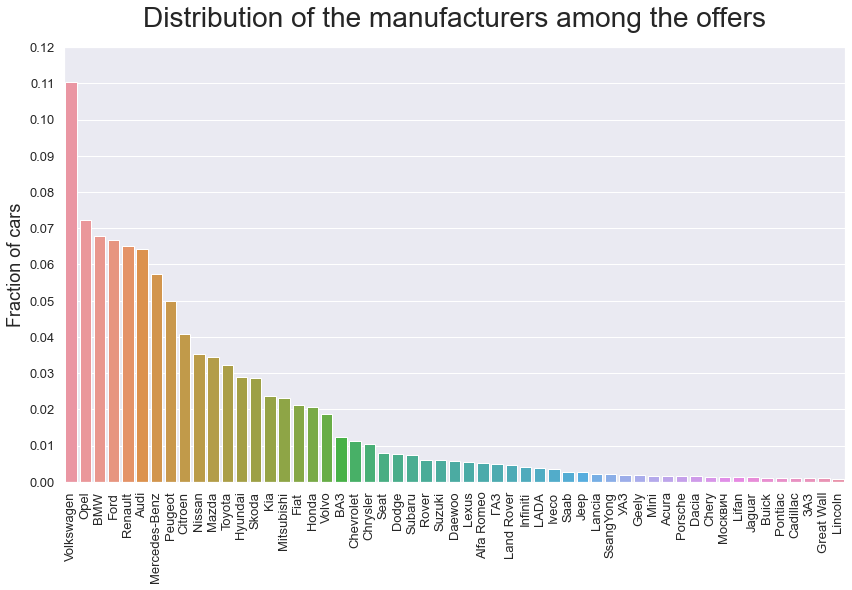

In [17]:
freq = df["manufacturer_name"].value_counts(normalize=True)
# In case you would like to only see some of the most common manufacturers:
    # freq = freq[freq > 0.01]

plt.figure(figsize=(14, 8))
sb.barplot(x=freq.index, y=freq)

plt.title("Distribution of the manufacturers among the offers", fontsize=28, pad=20)
plt.xticks(fontsize=13, rotation=90)
plt.ylabel("Fraction of cars", fontsize=18)
plt.yticks(np.arange(0, 0.13, 0.01), fontsize=13)

plt.show()

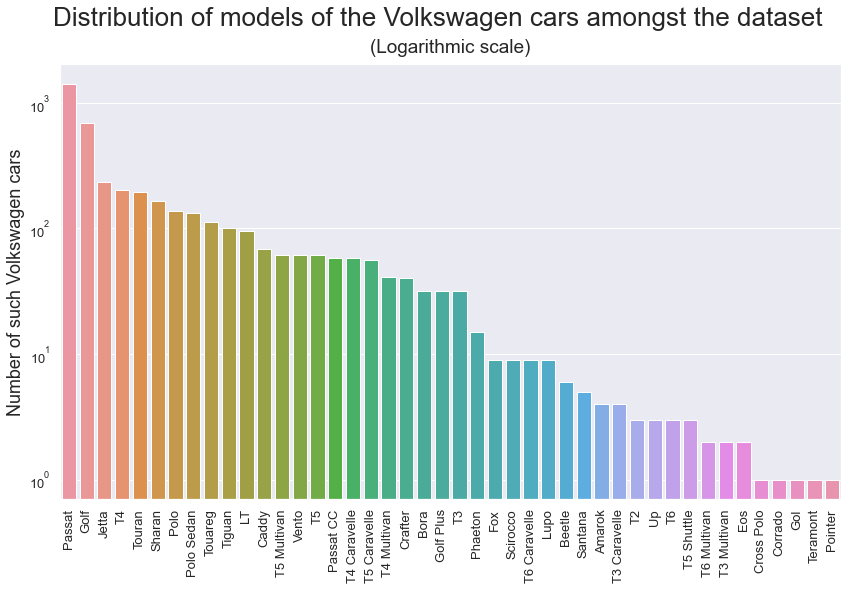

In [18]:
freq = df[df["manufacturer_name"] == "Volkswagen"]["model_name"].value_counts()
# In case you would like to only see some of the most common models:
    # freq = freq[freq > 0.01]

plt.figure(figsize=(14, 8))
sb.barplot(x=freq.index, y=freq, log=True)

plt.suptitle("Distribution of models of the Volkswagen cars amongst the dataset", fontsize=26)
plt.title("(Logarithmic scale)", fontsize=19, pad=12)
plt.xticks(fontsize=13, rotation=90)
plt.ylabel("Number of such Volkswagen cars", fontsize=18)
plt.yticks(fontsize=13)

plt.show()

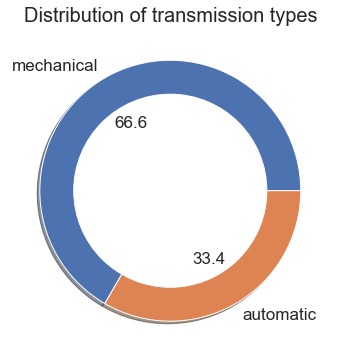

In [19]:
sizes = df["transmission"].value_counts(normalize=True)
transmissions = sizes.index

fig1, ax1 = plt.subplots(figsize=(6, 6))
ax1.pie(sizes, labels=transmissions, shadow=True, textprops={"size": 17}, autopct="%.1f")
plt.gcf().gca().add_artist(plt.Circle((0, 0), 0.74, color="white"))
plt.title("Distribution of transmission types", fontsize=20)

plt.show()

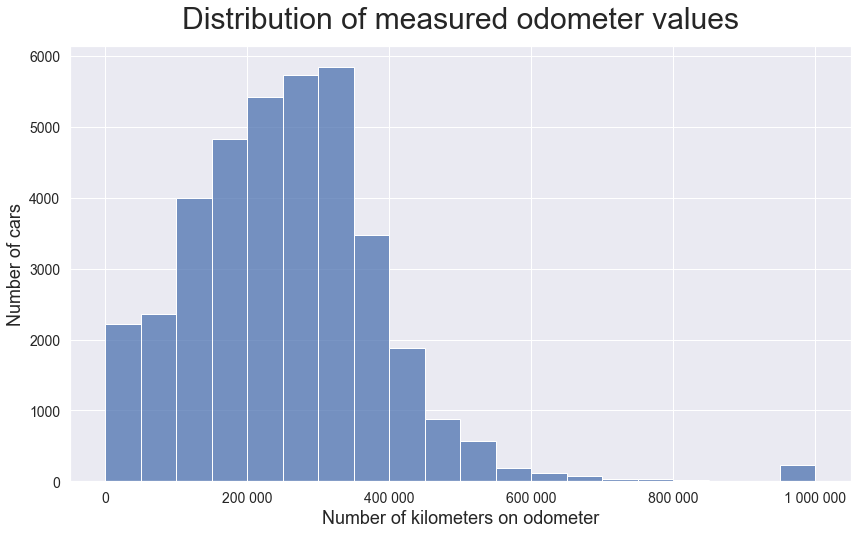

In [20]:
plt.figure(figsize=(14, 8))
sb.histplot(data=df["odometer_value"], binwidth=50000)

plt.title("Distribution of measured odometer values", fontsize=30, pad=18)
plt.xlabel("Number of kilometers on odometer", fontsize=18)
plt.xticks(range(0, 1000001, 200000), 
           labels=[f"{x:,}".replace(",", " ") for x in range(0, 1000001, 200000)], fontsize=14)
plt.ylabel("Number of cars", fontsize=18)
plt.yticks(fontsize=14)
plt.gca().xaxis.get_offset_text().set_size(16)

plt.show()

In [21]:
plt.figure(figsize=(14, 8))
sb.histplot(data=df["year_produced"], bins=range(1940, 2021, 5))

plt.title("Distribution of production years", fontsize=30, pad=18)
plt.xlabel("Year of production", fontsize=18)
plt.xticks(range(1940, 2021, 5), fontsize=14)
plt.ylabel("Number of cars", fontsize=18)
plt.yticks(fontsize=14)

plt.show()

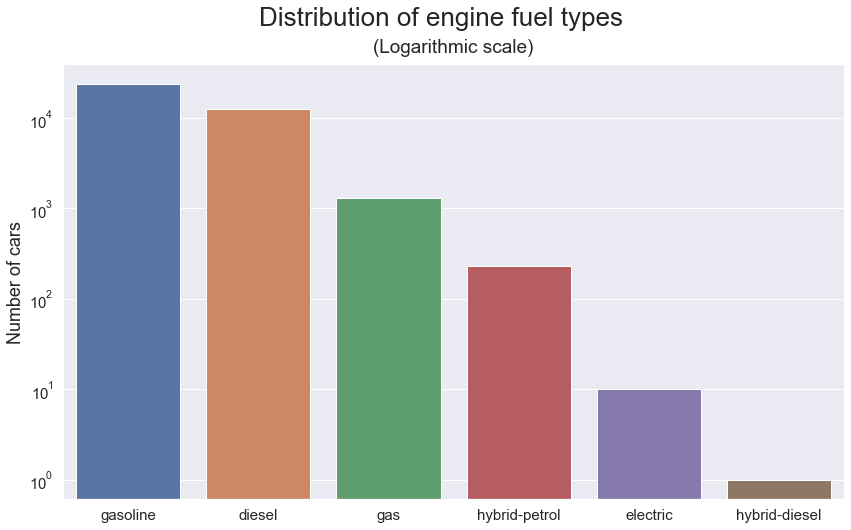

In [22]:
freq = df["engine_fuel"].value_counts()

plt.figure(figsize=(14, 8))
sb.barplot(x=freq.index, y=freq, log=True)

plt.suptitle("Distribution of engine fuel types", fontsize=26)
plt.title("(Logarithmic scale)", fontsize=19, pad=12)
plt.xticks(fontsize=15)
plt.ylabel("Number of cars", fontsize=18)
plt.yticks(fontsize=15)

plt.show()

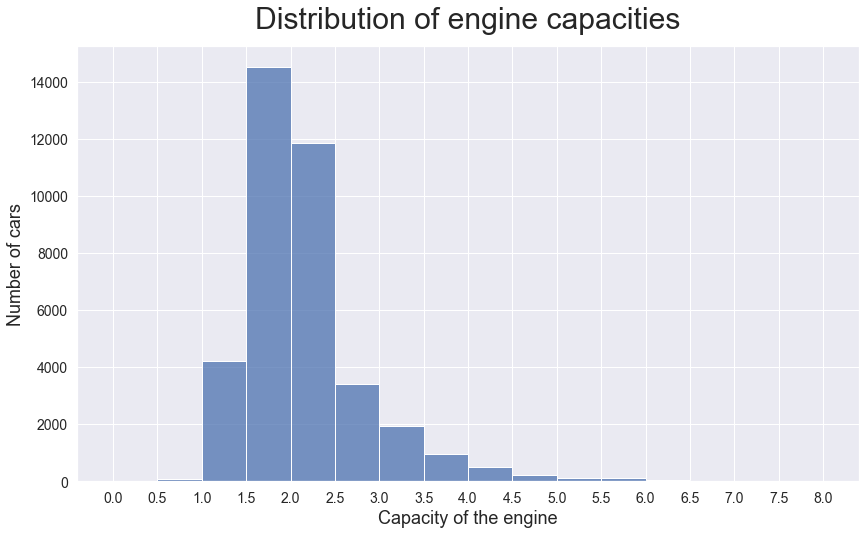

In [23]:
plt.figure(figsize=(14, 8))
sb.histplot(data=df["engine_capacity"], bins=np.arange(0, 8.1, 0.5))

plt.title("Distribution of engine capacities", fontsize=30, pad=18)
plt.xlabel("Capacity of the engine", fontsize=18)
plt.xticks(np.arange(0, 8.1, 0.5), fontsize=14)
plt.ylabel("Number of cars", fontsize=18)
plt.yticks(fontsize=14)

plt.show()

In [24]:
freq = df["body_type"].value_counts()

plt.figure(figsize=(14, 8))
sb.barplot(x=freq.index, y=freq, log=False)

plt.title("Distribution of body types", fontsize=26, pad=20)
plt.xticks(fontsize=14)
plt.ylabel("Number of cars", fontsize=18)
plt.yticks(fontsize=14)

plt.show()

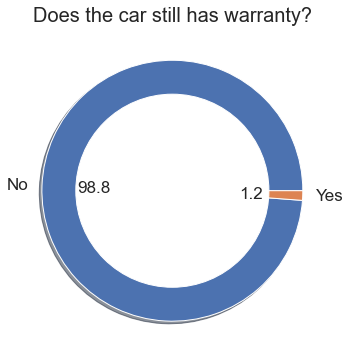

In [25]:
sizes = df["has_warranty"].value_counts(normalize=True)
warranties = sizes.rename({0: "No", 1: "Yes"}).index

fig1, ax1 = plt.subplots(figsize=(6, 6))
ax1.pie(sizes, labels=warranties, shadow=True, textprops={"size": 17}, autopct="%.1f")
plt.gcf().gca().add_artist(plt.Circle((0, 0), 0.74, color="white"))
plt.title("Does the car still has warranty?", fontsize=20)

plt.show()

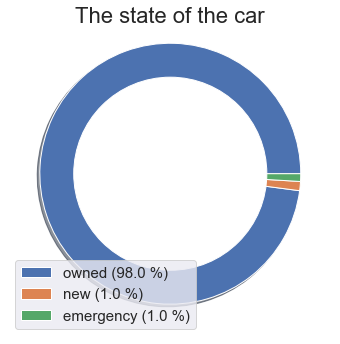

In [26]:
sizes = df["state"].value_counts(normalize=True)
labels = sizes.index
labels = [f"{lab} ({round(x, 2)*100} %)" for lab, x in zip(labels, sizes)]

fig1, ax1 = plt.subplots(figsize=(6, 6))
ax1.pie(sizes, shadow=True)
plt.gcf().gca().add_artist(plt.Circle((0, 0), 0.74, color="white"))
plt.title("The state of the car", fontsize=22, pad=-12)
plt.legend(labels, loc="lower left", fontsize=15)

plt.show()

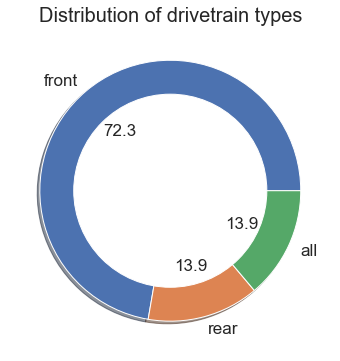

In [27]:
sizes = df["drivetrain"].value_counts(normalize=True)
drivetypes = sizes.index

fig1, ax1 = plt.subplots(figsize=(6, 6))
ax1.pie(sizes, labels=drivetypes, shadow=True, textprops={"size": 17}, autopct="%.1f")
plt.gcf().gca().add_artist(plt.Circle((0, 0), 0.74, color="white"))
plt.title("Distribution of drivetrain types", fontsize=20)

plt.show()

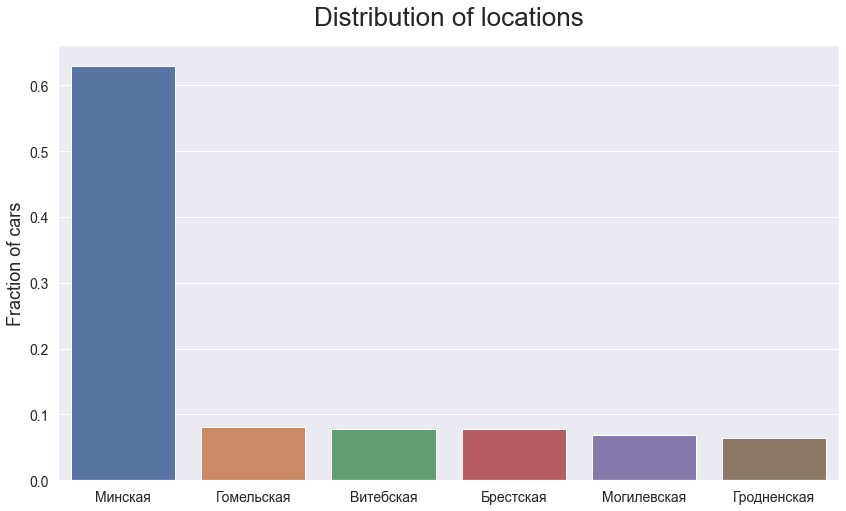

In [28]:
freq = df["location_region"].value_counts(normalize=True)

plt.figure(figsize=(14, 8))
sb.barplot(x=freq.index, y=freq)

plt.title("Distribution of locations", fontsize=26, pad=20)
plt.xticks(fontsize=14)
plt.ylabel("Fraction of cars", fontsize=18)
plt.yticks(fontsize=14)

plt.show()

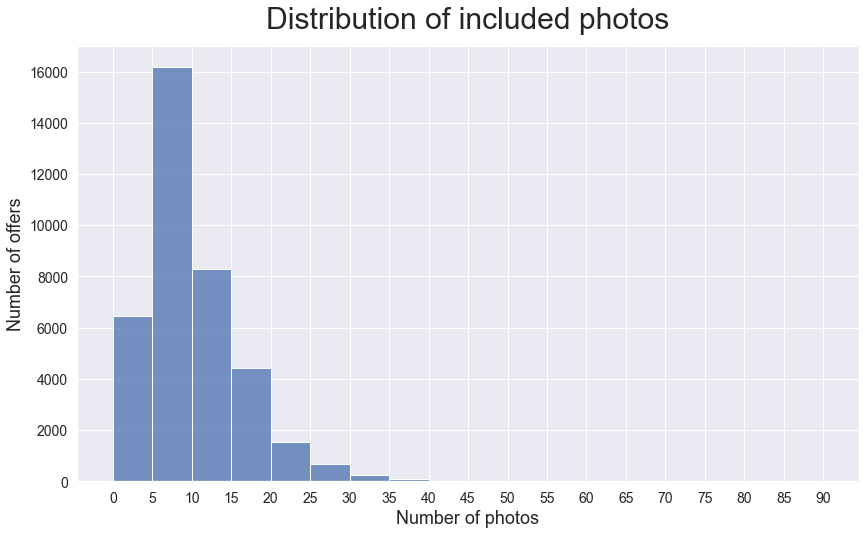

In [29]:
plt.figure(figsize=(14, 8))
sb.histplot(data=df["number_of_photos"], bins=range(0, 91, 5))

plt.title("Distribution of included photos", fontsize=30, pad=18)
plt.xlabel("Number of photos", fontsize=18)
plt.xticks(range(0, 91, 5), fontsize=14)
plt.ylabel("Number of offers", fontsize=18)
plt.yticks(fontsize=14)

plt.show()

In [30]:
plt.figure(figsize=(14, 8))
sb.histplot(data=df["up_counter"], bins=range(0, 361, 10))

plt.title("Distribution of upvotes among the offers", fontsize=30, pad=18)
plt.xlabel("Number of upvotes", fontsize=18)
plt.xticks(range(0, 361, 20), fontsize=14)
plt.ylabel("Number of offers", fontsize=18)
plt.yticks(fontsize=14)

plt.show()

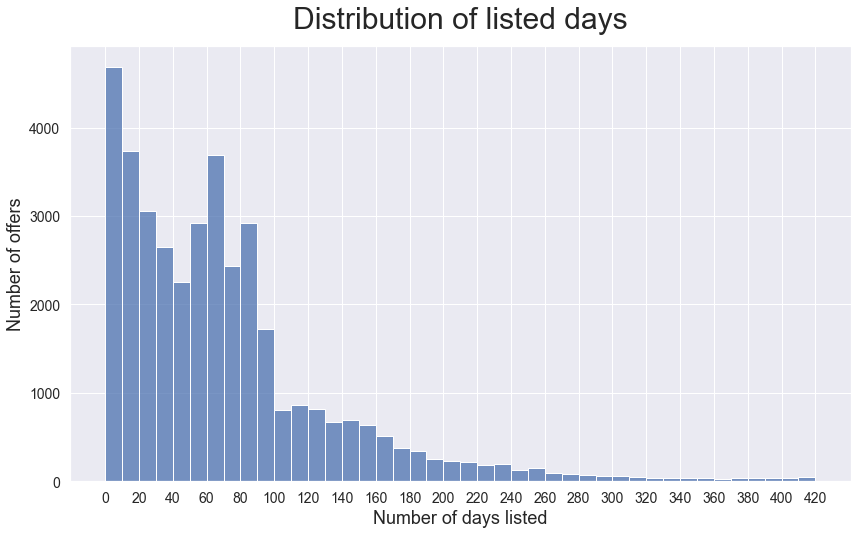

In [31]:
plt.figure(figsize=(14, 8))
sb.histplot(data=df["duration_listed"], bins=range(0, 421, 10))

plt.title("Distribution of listed days", fontsize=30, pad=18)
plt.xlabel("Number of days listed", fontsize=18)
plt.xticks(range(0, 421, 20), fontsize=14)
plt.ylabel("Number of offers", fontsize=18)
plt.yticks(fontsize=14)

plt.show()

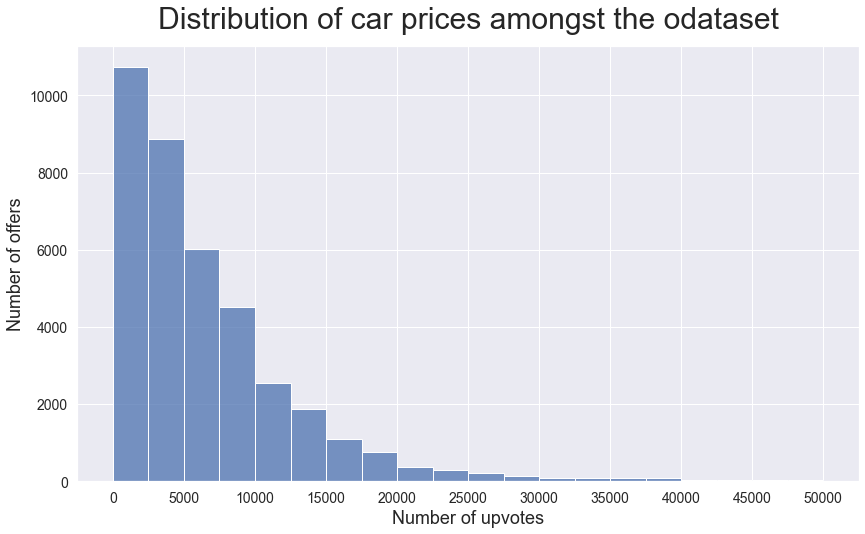

In [32]:
plt.figure(figsize=(14, 8))
sb.histplot(data=df["price_usd"], bins=range(0, 50001, 2500))

plt.title("Distribution of car prices amongst the odataset", fontsize=30, pad=18)
plt.xlabel("Number of upvotes", fontsize=18)
plt.xticks(range(0, 50001, 5000), fontsize=14)
plt.ylabel("Number of offers", fontsize=18)
plt.yticks(fontsize=14)

plt.show()

<h2>Bivariate and Multivariate Analysis</h2>

In [33]:
# This functions allows us to automate and parameterize our groupby queries

def n_top_bot(data, n, group_features, agg_target, limit=1,
              aggregators=["count", "min", "max", "mean"], sorter="mean"):
    sub_df = data.groupby(group_features)[agg_target].agg(aggregators).sort_values(by=sorter, ascending=False).astype(int)
    if "count" in aggregators:
        sub_df = sub_df[sub_df["count"] > limit]
    if len(sub_df) <= 2*n:
        return sub_df
    if len(group_features) == 1:
        appendix = sub_df.iloc[0].rename("...")
    else:
        appendix = sub_df.iloc[0].rename(tuple(["..."]*len(group_features)))
    appendix[:] = "..."
    return sub_df.head(n).append(appendix).append(sub_df.tail(n))

<h3>Model, car brand and vehicle type in relation to price</h3>

In [34]:
# The most and least expensive cars based on car brand

n_top_bot(df, 10, ["manufacturer_name"], "price_usd")

count   min    max   mean
manufacturer_name                          
Porsche              59  2999  47900  18347
Jaguar               47  2500  50000  18091
Lexus               210  2500  48610  17211
Land Rover          179  2800  49950  15296
Infiniti            159  4200  47000  13841
Skoda              1083   300  44947  13798
Mini                 66  4099  39456  13229
Acura                63  2350  36500  12738
Buick                46  5300  24000  12710
Cadillac             41  1700  25750  11085
...                 ...   ...    ...    ...
Seat                302   162  18350   3874
УАЗ                  71   379  15000   3543
Lancia               87   200   9500   2926
Fiat                808   150  34118   2886
Alfa Romeo          199   104  22000   2707
Rover               233   200   9900   1737
Daewoo              219   100   6700   1581
ВАЗ                 471    60  12804   1514
ЗАЗ                  39   150   4300   1326
Москвич              50   149  10000    900

In [35]:
# The most and least expensive car models based on mean price (models with one entry only excluded)

n_top_bot(df, 10, ["manufacturer_name", "model_name"], "price_usd")

count    min    max   mean
manufacturer_name model_name                           
Mercedes-Benz     GL63           2  47000  49999  48499
Volvo             V90            2  41400  48200  44800
Mercedes-Benz     GLE350         2  42900  43913  43406
                  GLE300         2  39900  44850  42375
                  V250           5  34450  45000  41995
Porsche           Macan          3  35900  47900  40766
Mercedes-Benz     CLS400         3  34800  48000  39766
Jaguar            F-Pace         4  31900  42000  39200
Mercedes-Benz     GL400          2  35250  42000  38625
                  E400           2  26500  49000  37750
...               ...          ...    ...    ...    ...
Opel              Kadett        31    224   1000    444
Volvo             340            3    400    460    428
Volkswagen        Santana        5    359    500    426
Renault           11             2    350    500    425
Skoda             Favorit        2    350    500    425
Ford              Orion         16    150    700    419
ЗАЗ               968м          13    150   1100    419
                  Таврия         9    250    700    386
Seat              Malaga         2    213    350    281
Москвич           2125           2    200    235    217

In [36]:
# The most and least expensive vehicle types based on mean price

n_top_bot(df, 10, ["body_type"], "price_usd")

count   min    max   mean
body_type                           
suv         5051   300  50000  13774
pickup       118   450  36000  11895
cabriolet     67   800  48000  11012
minibus     1330   350  48182   8414
limousine     11  4000  15300   7940
liftback     552   250  39999   7859
coupe        640   150  50000   7386
van          783   300  40000   6559
minivan     3561   260  48000   6109
sedan      12825     9  49950   5786
universal   5427   100  48200   4993
hatchback   7559    60  40500   4029

In [37]:
# The most and least expensive vehicle types + car brands based on mean price

n_top_bot(df, 10, ["body_type", "manufacturer_name"], "price_usd")

count    min    max   mean
body_type manufacturer_name                           
suv       Jaguar                4  31900  42000  39200
          Skoda               150   7400  41850  31145
liftback  Porsche               3  22500  34900  28766
cabriolet Mercedes-Benz         8  13499  48000  26435
suv       Mini                 10  11950  39456  21411
minibus   Chevrolet             3  15900  28000  21266
pickup    Dodge                11   5500  35900  20995
liftback  BMW                  20   1500  39999  20737
suv       Lexus               102   4800  48610  20393
coupe     Cadillac              5   5500  25750  20260
...       ...                 ...    ...    ...    ...
sedan     ВАЗ                 274    145  10500   1179
liftback  Kia                   5    500   1800   1170
          Seat                 12    350   2000   1115
hatchback ГАЗ                   3    616   2000   1105
coupe     Seat                  3    899   1500   1099
sedan     Москвич              39    150  10000    984
hatchback ВАЗ                 106     60   3800    929
          Москвич               8    149   2000    599
coupe     ЗАЗ                   6    150    600    351
universal Москвич               2    235    250    242

<h3>General car properties in relation to price and other variables</h3>

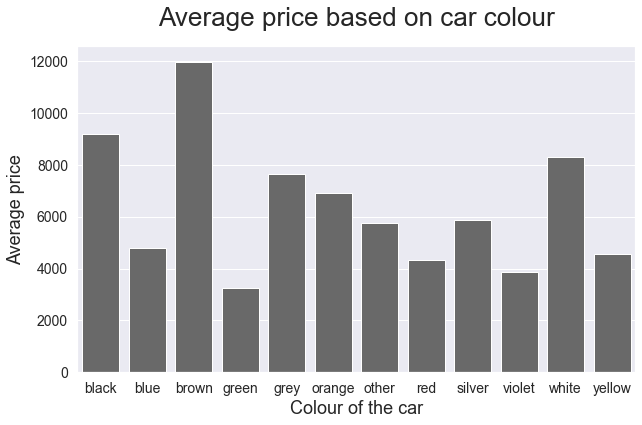

In [38]:
sub_df = df.groupby(["color"]).price_usd.agg(["mean"]).astype(int).reset_index()

plt.figure(figsize=(10, 6))
sb.barplot(data=sub_df, x="color", y="mean", color="dimgray")

plt.title("Average price based on car colour", fontsize=26, pad=20)
plt.xlabel("Colour of the car", fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel("Average price", fontsize=18)
plt.yticks(fontsize=14)

plt.show()

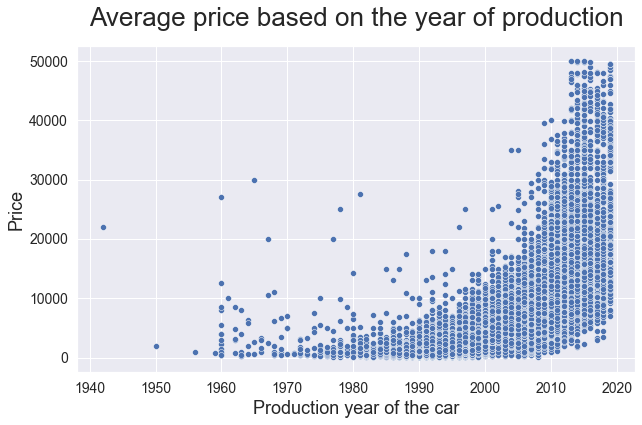

In [39]:
plt.figure(figsize=(10, 6))
sb.scatterplot(data=df, x="year_produced", y="price_usd")

plt.title("Average price based on the year of production", fontsize=26, pad=20)
plt.xlabel("Production year of the car", fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel("Price", fontsize=18)
plt.yticks(fontsize=14)

plt.show()

In [40]:
plt.figure(figsize=(10, 6))
sb.boxplot(data=df, x="location_region", y="price_usd", palette="husl")

plt.title("Average price based on the location", fontsize=26, pad=20)
plt.xlabel("Location of the offer", fontsize=18)
plt.xticks(fontsize=13)
plt.ylabel("Average price", fontsize=18)
plt.yticks(fontsize=13)

plt.show()

In [41]:
# Relation between car state, warranty status and price

df.groupby(["state", "has_warranty"]).price_usd.agg(["count", "min", "max", "mean"]).astype(int).rename({0: "No", 1: "Yes"})

count    min    max   mean
state     has_warranty                            
emergency No              360      9  25000   1751
new       No               53   7806  49500  27439
          Yes             375  13942  47000  24730
owned     No            37063     10  50000   6423
          Yes              73   1850  43999  17642

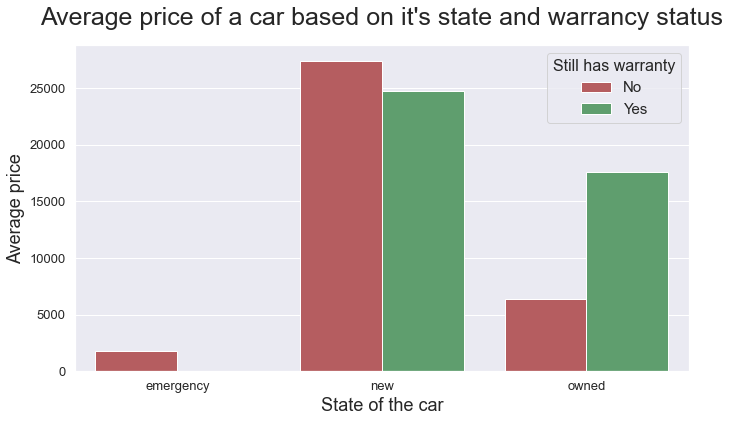

In [42]:
sub_df = df.groupby(["state", "has_warranty"]).price_usd.agg(["mean"]).astype(int).rename({0: "No", 1: "Yes"}).reset_index()

plt.figure(figsize=(11, 6))
sb.barplot(x="state", y="mean", data=sub_df, hue="has_warranty", palette=["r", "g"])

plt.title("Average price of a car based on it's state and warrancy status", fontsize=25, pad=20)
plt.xlabel("State of the car", fontsize=18)
plt.xticks(fontsize=13)
plt.ylabel("Average price", fontsize=18)
plt.yticks(fontsize=13)
plt.legend(title="Still has warranty", title_fontsize=16, fontsize=15, loc=0)

plt.show()

In [43]:
# Price of the car based on transmission type and engine fuel

df.groupby(["transmission", "engine_fuel"]).price_usd.agg(["count", "min", "max", "mean"]).astype(int)

# We can see that cars with automatic transmission are in general much more expensive
# This will most likely correlate with year of production and state of the car as well

# There are none electric cars with mechanical transmission and there is only one hybrid-diesel car in the dataset

count   min    max   mean
transmission engine_fuel                             
automatic    diesel          3091   250  50000  12810
             electric          10  9300  39999  17464
             gas              499   200  37500   6944
             gasoline        8841   150  50000  10456
             hybrid-petrol    212  1350  38000  11774
mechanical   diesel          9558   100  43000   5619
             gas              820   180  22000   3039
             gasoline       14873     9  47400   3782
             hybrid-diesel      1   400    400    400
             hybrid-petrol     19   400  17690   4695

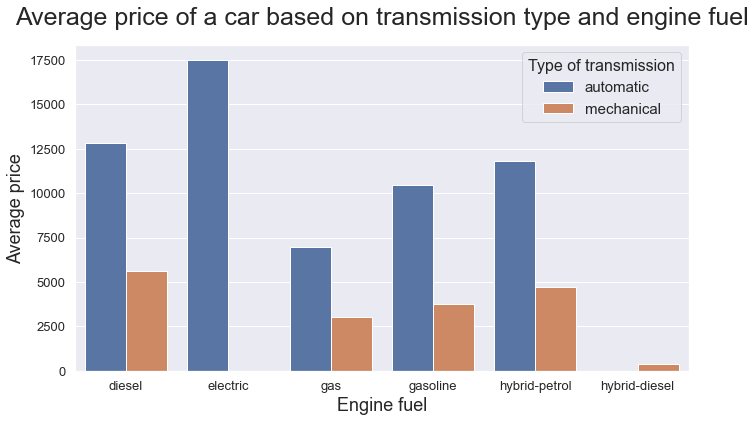

In [44]:
sub_df = df.groupby(["transmission", "engine_fuel"]).price_usd.agg(["mean"]).astype(int).reset_index()

plt.figure(figsize=(11, 6))
sb.barplot(x="engine_fuel", y="mean", data=sub_df, hue="transmission", palette="deep")

plt.title("Average price of a car based on transmission type and engine fuel", fontsize=25, pad=20)
plt.xlabel("Engine fuel", fontsize=18)
plt.xticks(fontsize=13)
plt.ylabel("Average price", fontsize=18)
plt.yticks(fontsize=13)
plt.legend(title="Type of transmission", title_fontsize=16, fontsize=15, loc=1)

plt.show()

In [45]:
# Relations betweeen transmission type, engine fuel and production year

df.groupby(["transmission", "engine_fuel"]).year_produced.agg(["count", "min", "max", "mean"]).astype(int)

count   min   max  mean
transmission engine_fuel                           
automatic    diesel          3091  1980  2019  2006
             electric          10  2011  2018  2014
             gas              499  1986  2018  2003
             gasoline        8841  1978  2019  2007
             hybrid-petrol    212  1991  2019  2010
mechanical   diesel          9558  1960  2019  2001
             gas              820  1964  2019  1997
             gasoline       14873  1942  2019  2000
             hybrid-diesel      1  1988  1988  1988
             hybrid-petrol     19  1984  2014  2000

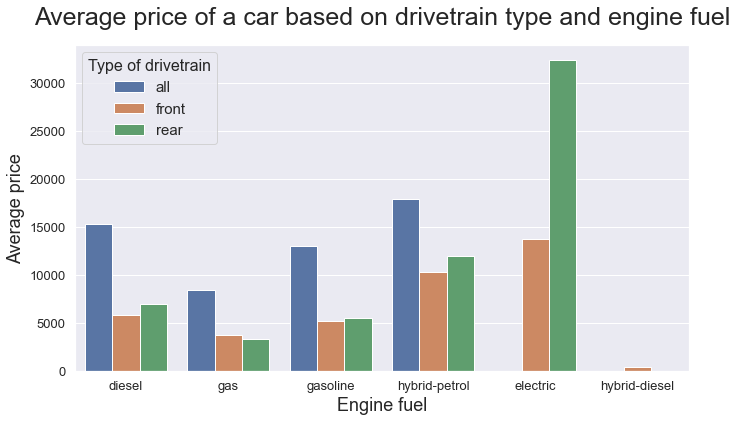

In [46]:
sub_df = df.groupby(["drivetrain", "engine_fuel"]).price_usd.agg(["mean"]).astype(int).reset_index()

plt.figure(figsize=(11, 6))
sb.barplot(x="engine_fuel", y="mean", data=sub_df, hue="drivetrain", palette="deep")

plt.title("Average price of a car based on drivetrain type and engine fuel", fontsize=25, pad=20)
plt.xlabel("Engine fuel", fontsize=18)
plt.xticks(fontsize=13)
plt.ylabel("Average price", fontsize=18)
plt.yticks(fontsize=13)
plt.legend(title="Type of drivetrain", title_fontsize=16, fontsize=15, loc=0)

plt.show()

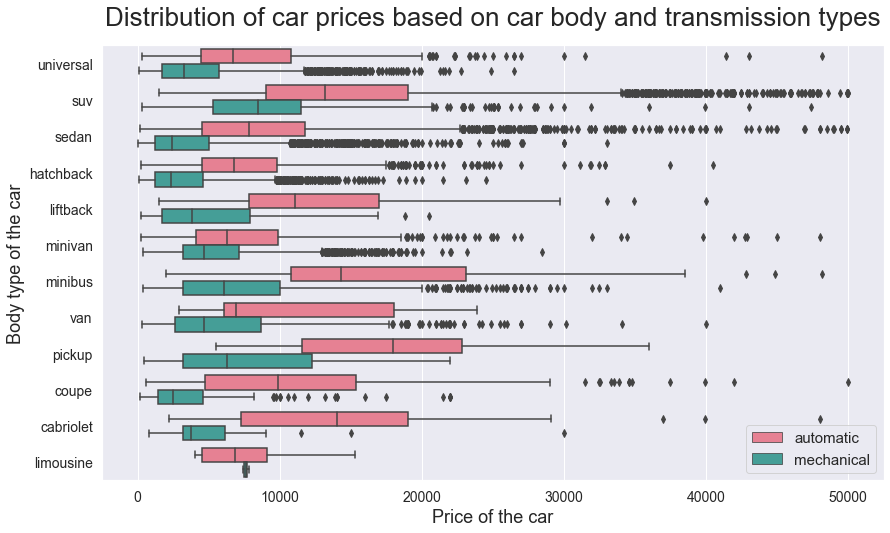

In [47]:
plt.figure(figsize=(14, 8))
sb.boxplot(data=df, x="price_usd", y="body_type", hue="transmission", palette="husl")

plt.title("Distribution of car prices based on car body and transmission types", fontsize=26, pad=20)
plt.xlabel("Price of the car", fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel("Body type of the car", fontsize=18)
plt.yticks(fontsize=14)
plt.legend(fontsize=15)

plt.show()

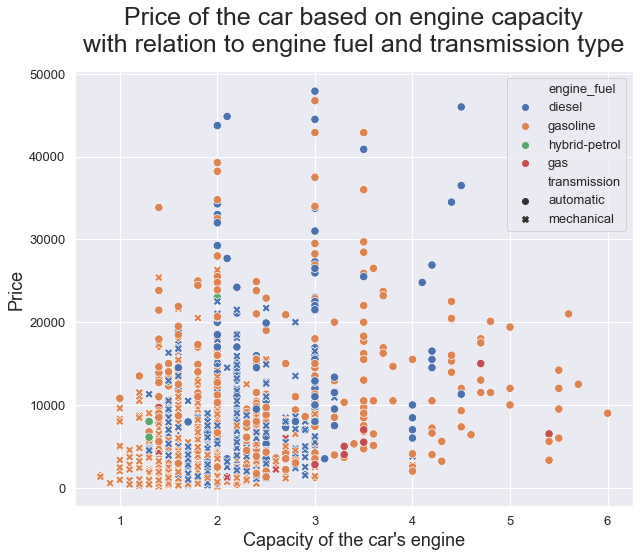

In [48]:
plt.figure(figsize=(10, 8))
sb.scatterplot(data=df.sample(2000), x="engine_capacity", y="price_usd", 
               hue="engine_fuel", style="transmission", s=70)

plt.title("Price of the car based on engine capacity\nwith relation to engine fuel and transmission type", 
          fontsize=25, pad=20)
plt.xlabel("Capacity of the car's engine", fontsize=18)
plt.xticks(fontsize=13)
plt.ylabel("Price", fontsize=18)
plt.yticks(fontsize=13)
plt.legend(fontsize=13)

plt.show()

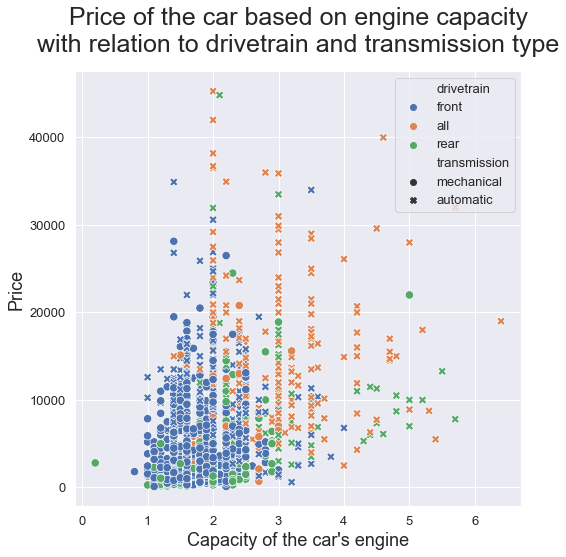

In [49]:
plt.figure(figsize=(8, 8))
sb.scatterplot(data=df.sample(2000), x="engine_capacity", y="price_usd", 
               hue="drivetrain", style="transmission", s=70)

plt.title("Price of the car based on engine capacity\nwith relation to drivetrain and transmission type", 
          fontsize=25, pad=20)
plt.xlabel("Capacity of the car's engine", fontsize=18)
plt.xticks(fontsize=13)
plt.ylabel("Price", fontsize=18)
plt.yticks(fontsize=13)
plt.legend(fontsize=13)

plt.show()

In [50]:
plt.figure(figsize=(8, 8))
sb.scatterplot(data=df.sample(2000), x="odometer_value", y="price_usd", hue="transmission")

plt.title("Price of the car based on odometer value\nwith relation to the transmission type of the car", fontsize=25, pad=20)
plt.xlabel("Value of the odometer", fontsize=18)
plt.xticks(range(0, 1000001, 250000), 
           labels=[f"{x:,}".replace(",", " ") for x in range(0, 1000001, 250000)], fontsize=13)
plt.ylabel("Price", fontsize=18)
plt.yticks(fontsize=13)
plt.legend(fontsize=16)

plt.show()

In [51]:
fig, axs = plt.subplots(figsize=(8, 8))
sb.scatterplot(data=df.sample(2000), x="year_produced", y="odometer_value", 
               hue="transmission", size="price_usd", sizes=(15, 100), ax=axs)

plt.title("Value on the odometer based\non the year of production with relation to price", fontsize=25, pad=20)
plt.xlabel("Year of production", fontsize=18)
plt.xticks(fontsize=13)
plt.ylabel("Odometer value", fontsize=18)
plt.yticks(range(0, 1000001, 200000), 
           labels=[f"{x:,}".replace(",", " ") for x in range(0, 1000001, 200000)], fontsize=13)
plt.legend(fontsize=13, loc=1)

plt.plot([0, 1], [1, 0], transform=axs.transAxes, color="r")

plt.show()

<h3>Social analysis - upvotes, number of photos, duration listed and their relations to other variables</h3>

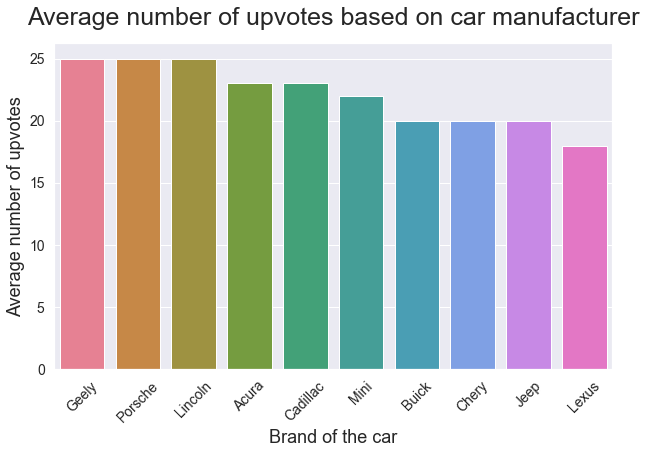

In [52]:
sub_df = df.groupby(["manufacturer_name"]).up_counter.agg(["mean"]).astype(int).sort_values(ascending=False, by="mean").reset_index()[:10]

plt.figure(figsize=(10, 6))
sb.barplot(data=sub_df, x="manufacturer_name", y="mean", palette="husl")

plt.title("Average number of upvotes based on car manufacturer", fontsize=25, pad=18)
plt.xlabel("Brand of the car", fontsize=18)
plt.xticks(fontsize=14, rotation=45)
plt.ylabel("Average number of upvotes", fontsize=18)
plt.yticks(fontsize=14)

plt.show()

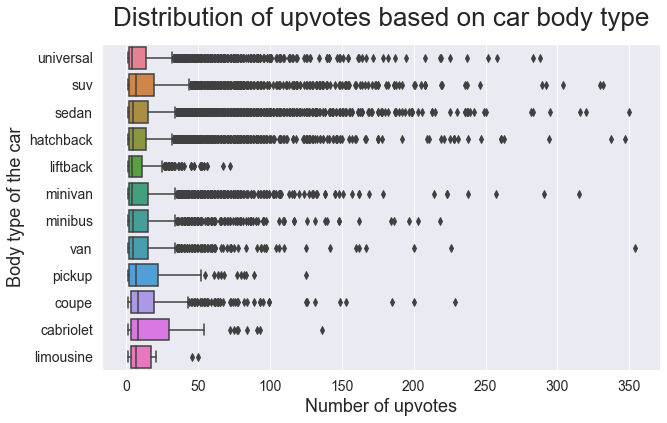

In [53]:
plt.figure(figsize=(10, 6))
sb.boxplot(x=df["up_counter"], y=df["body_type"], palette="husl")

plt.title("Distribution of upvotes based on car body type", fontsize=26, pad=18)
plt.xlabel("Number of upvotes", fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel("Body type of the car", fontsize=18)
plt.yticks(fontsize=14)

plt.show()

In [54]:
sub_df = df.groupby(["color"]).up_counter.agg(["mean"]).astype(int).reset_index()

plt.figure(figsize=(10, 6))
sb.barplot(data=sub_df, x="color", y="mean", color="dimgray")

plt.title("Average number of upvotes based on car colour", fontsize=26, pad=20)
plt.xlabel("Colour of the car", fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel("Average number of upvotes", fontsize=18)
plt.yticks(fontsize=14)

plt.show()

In [55]:
plt.figure(figsize=(8, 8))
sb.scatterplot(data=df.sample(5000), x="up_counter", y="price_usd", color="royalblue")

plt.title("Relation of the number of upvotes and price", fontsize=25, pad=20)
plt.xlabel("Number of upvotes", fontsize=18)
plt.xticks(fontsize=13)
plt.ylabel("Price in usd", fontsize=18)
plt.yticks(fontsize=13)

plt.show()

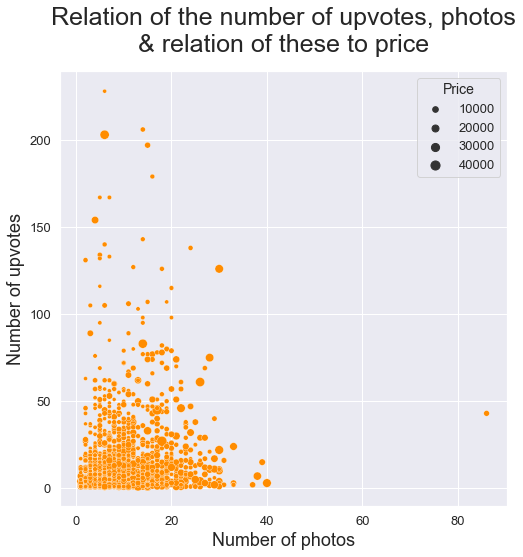

In [56]:
plt.figure(figsize=(8, 8))
sb.scatterplot(data=df.sample(2000), x="number_of_photos", y="up_counter", 
               size="price_usd", sizes=(15, 100), color="darkorange")

plt.title("Relation of the number of upvotes, photos\n& relation of these to price", fontsize=25, pad=20)
plt.xlabel("Number of photos", fontsize=18)
plt.xticks(fontsize=13)
plt.ylabel("Number of upvotes", fontsize=18)
plt.yticks(fontsize=13)
plt.legend(title="Price", title_fontsize=14, fontsize=13)

plt.show()

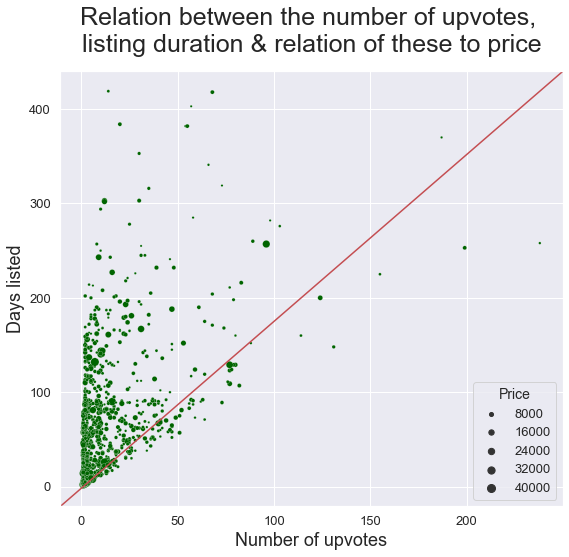

In [57]:
fig, axs = plt.subplots(figsize=(9, 8))
sb.scatterplot(data=df.sample(1000), x="up_counter", y="duration_listed", 
               size="price_usd", sizes=(5, 70), color="darkgreen", ax=axs)

plt.title("Relation between the number of upvotes, \nlisting duration & relation of these to price", fontsize=25, pad=20)
plt.xlabel("Number of upvotes", fontsize=18)
plt.xticks(fontsize=13)
plt.ylabel("Days listed", fontsize=18)
plt.yticks(fontsize=13)
plt.legend(title="Price", title_fontsize=14, fontsize=13)

axs.plot([0, 1], [0, 1], transform=axs.transAxes, color="r")

plt.show()

<h3>Features feature_0-feature_9 analysis</h3>

In [ ]:
# We will analyse features "feature_0"-"feature_9" (boolean) as well
    # +: Model accuracy, less bias, more versatile analysis
    # -: Less interpretability, none possible initial hypotheses regarding these features
    
# Note: These features have been analysed separately, since we do not know what information they possess

In [59]:
features = [f"feature_{i}" for i in range(0, 10)]

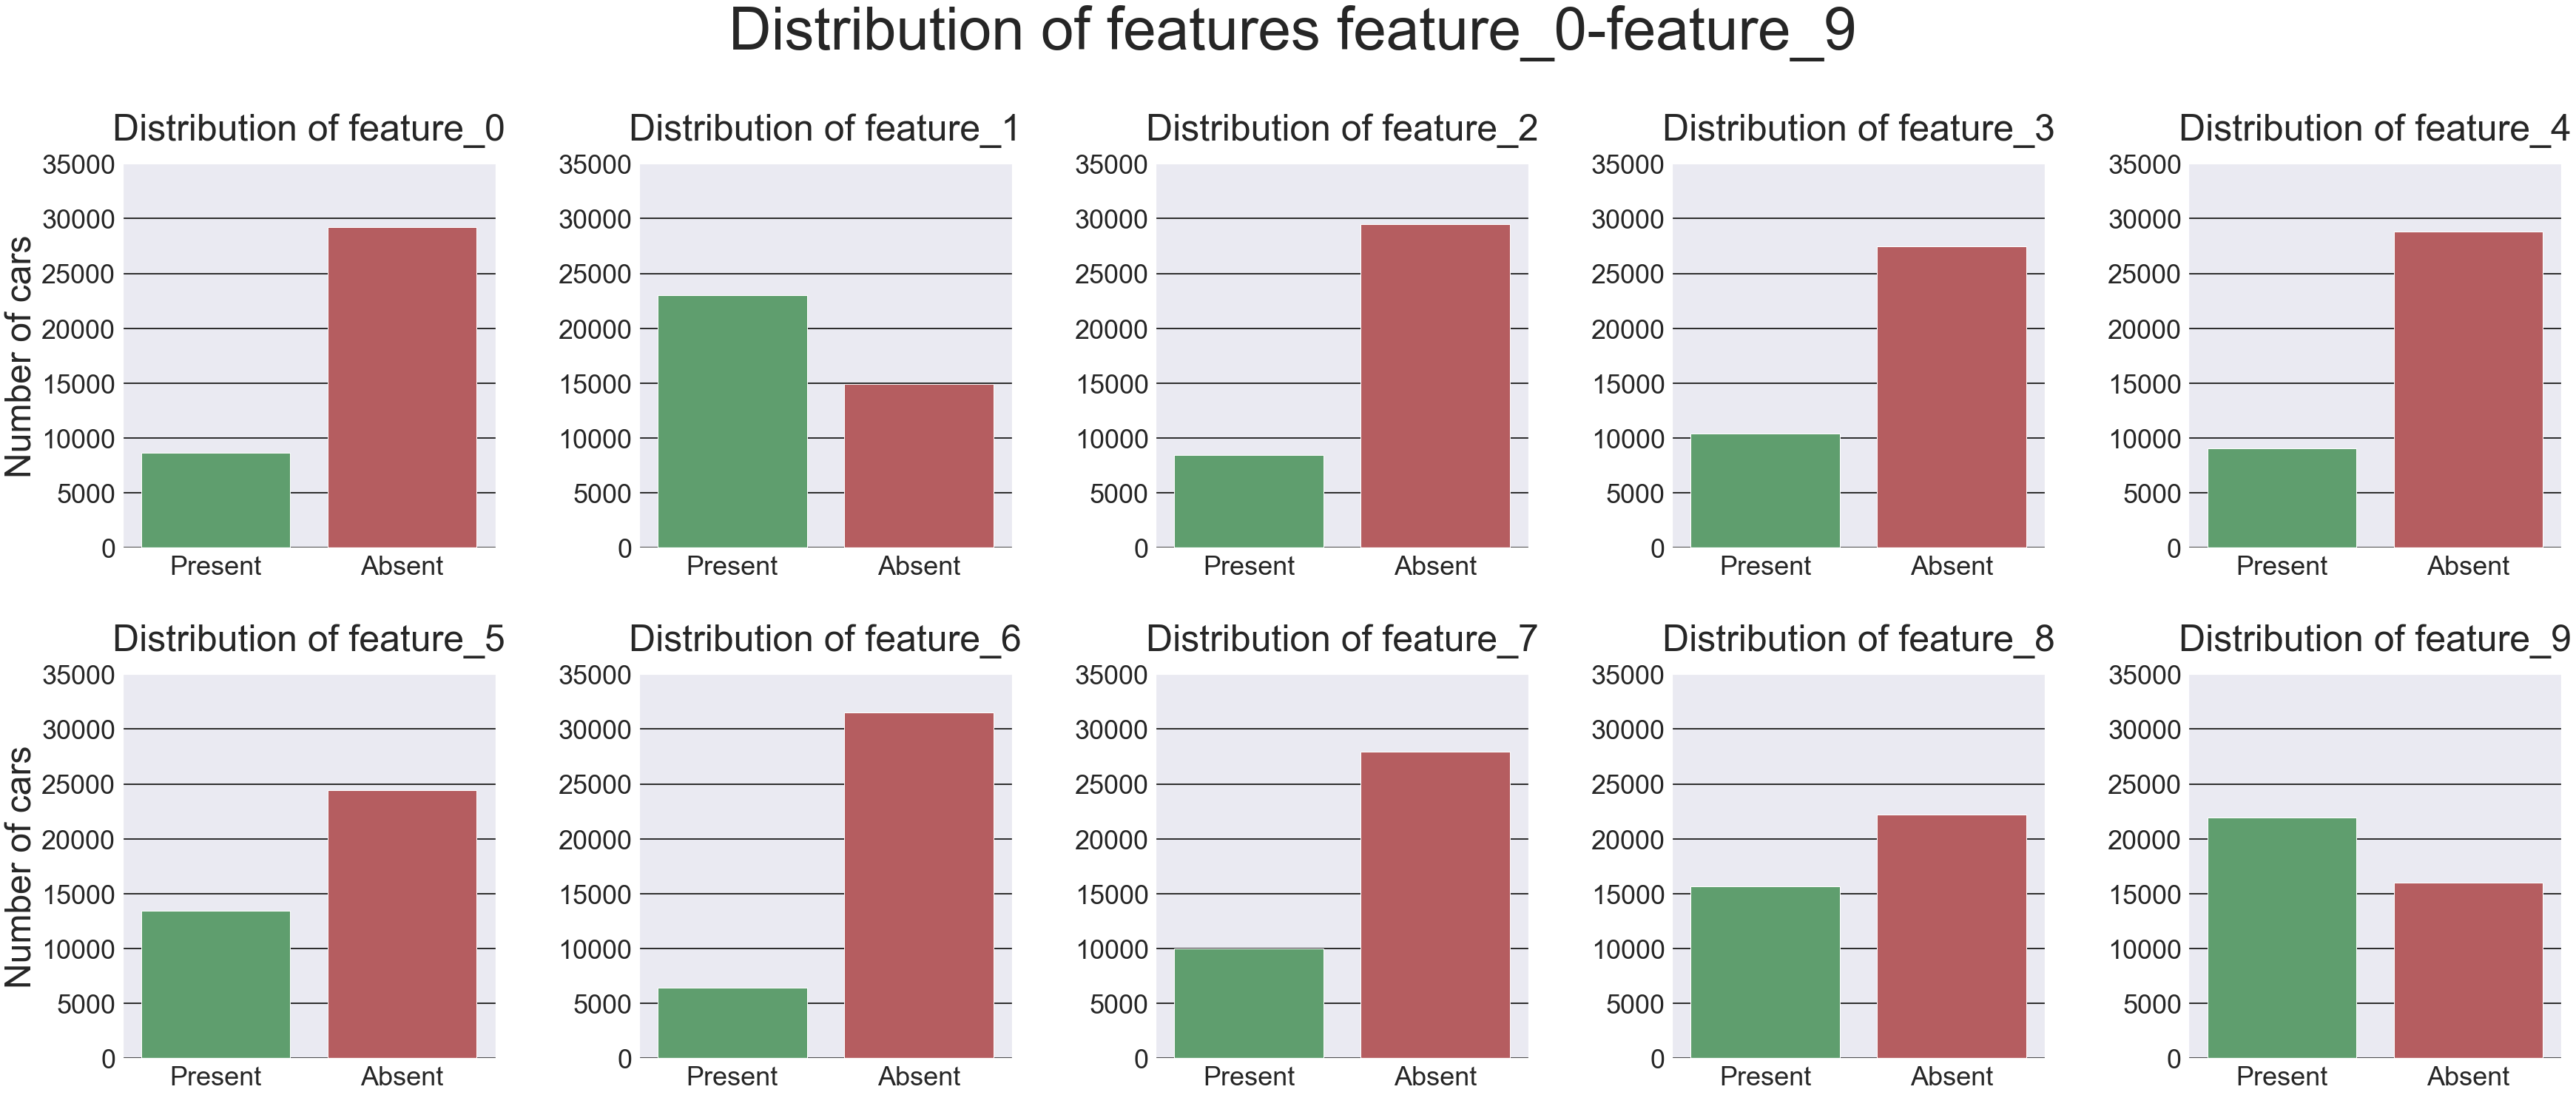

In [60]:
fig, axs = plt.subplots(2, 5, figsize=(50, 20))
fig.suptitle("Distribution of features feature_0-feature_9", fontsize=80, y=1.06)

i = 0
for x in range(2):
    for y in range(5):
        feature = features[i]
        freq = df[feature].value_counts().rename({0: "Absent", 1: "Present"}).sort_index(ascending=False)
        sb.barplot(x=freq.index, y=freq, 
                  ax=axs[x, y], palette=["g", "r"])
        axs[x, y].set_title(f"Distribution of {feature}", size=50, pad=32)
        axs[x, y].set_xlabel("")
        axs[x, y].set_ylabel("Number of cars", fontsize=48)
        axs[x, y].set_yticks(range(0, 35001, 5000))
        axs[x, y].tick_params(labelsize=36)
        axs[x, y].grid(which="both", axis="y", linewidth=1.8, color="k")
        if y:
            axs[x, y].set_ylabel("")
        i += 1

fig.tight_layout(pad=5)

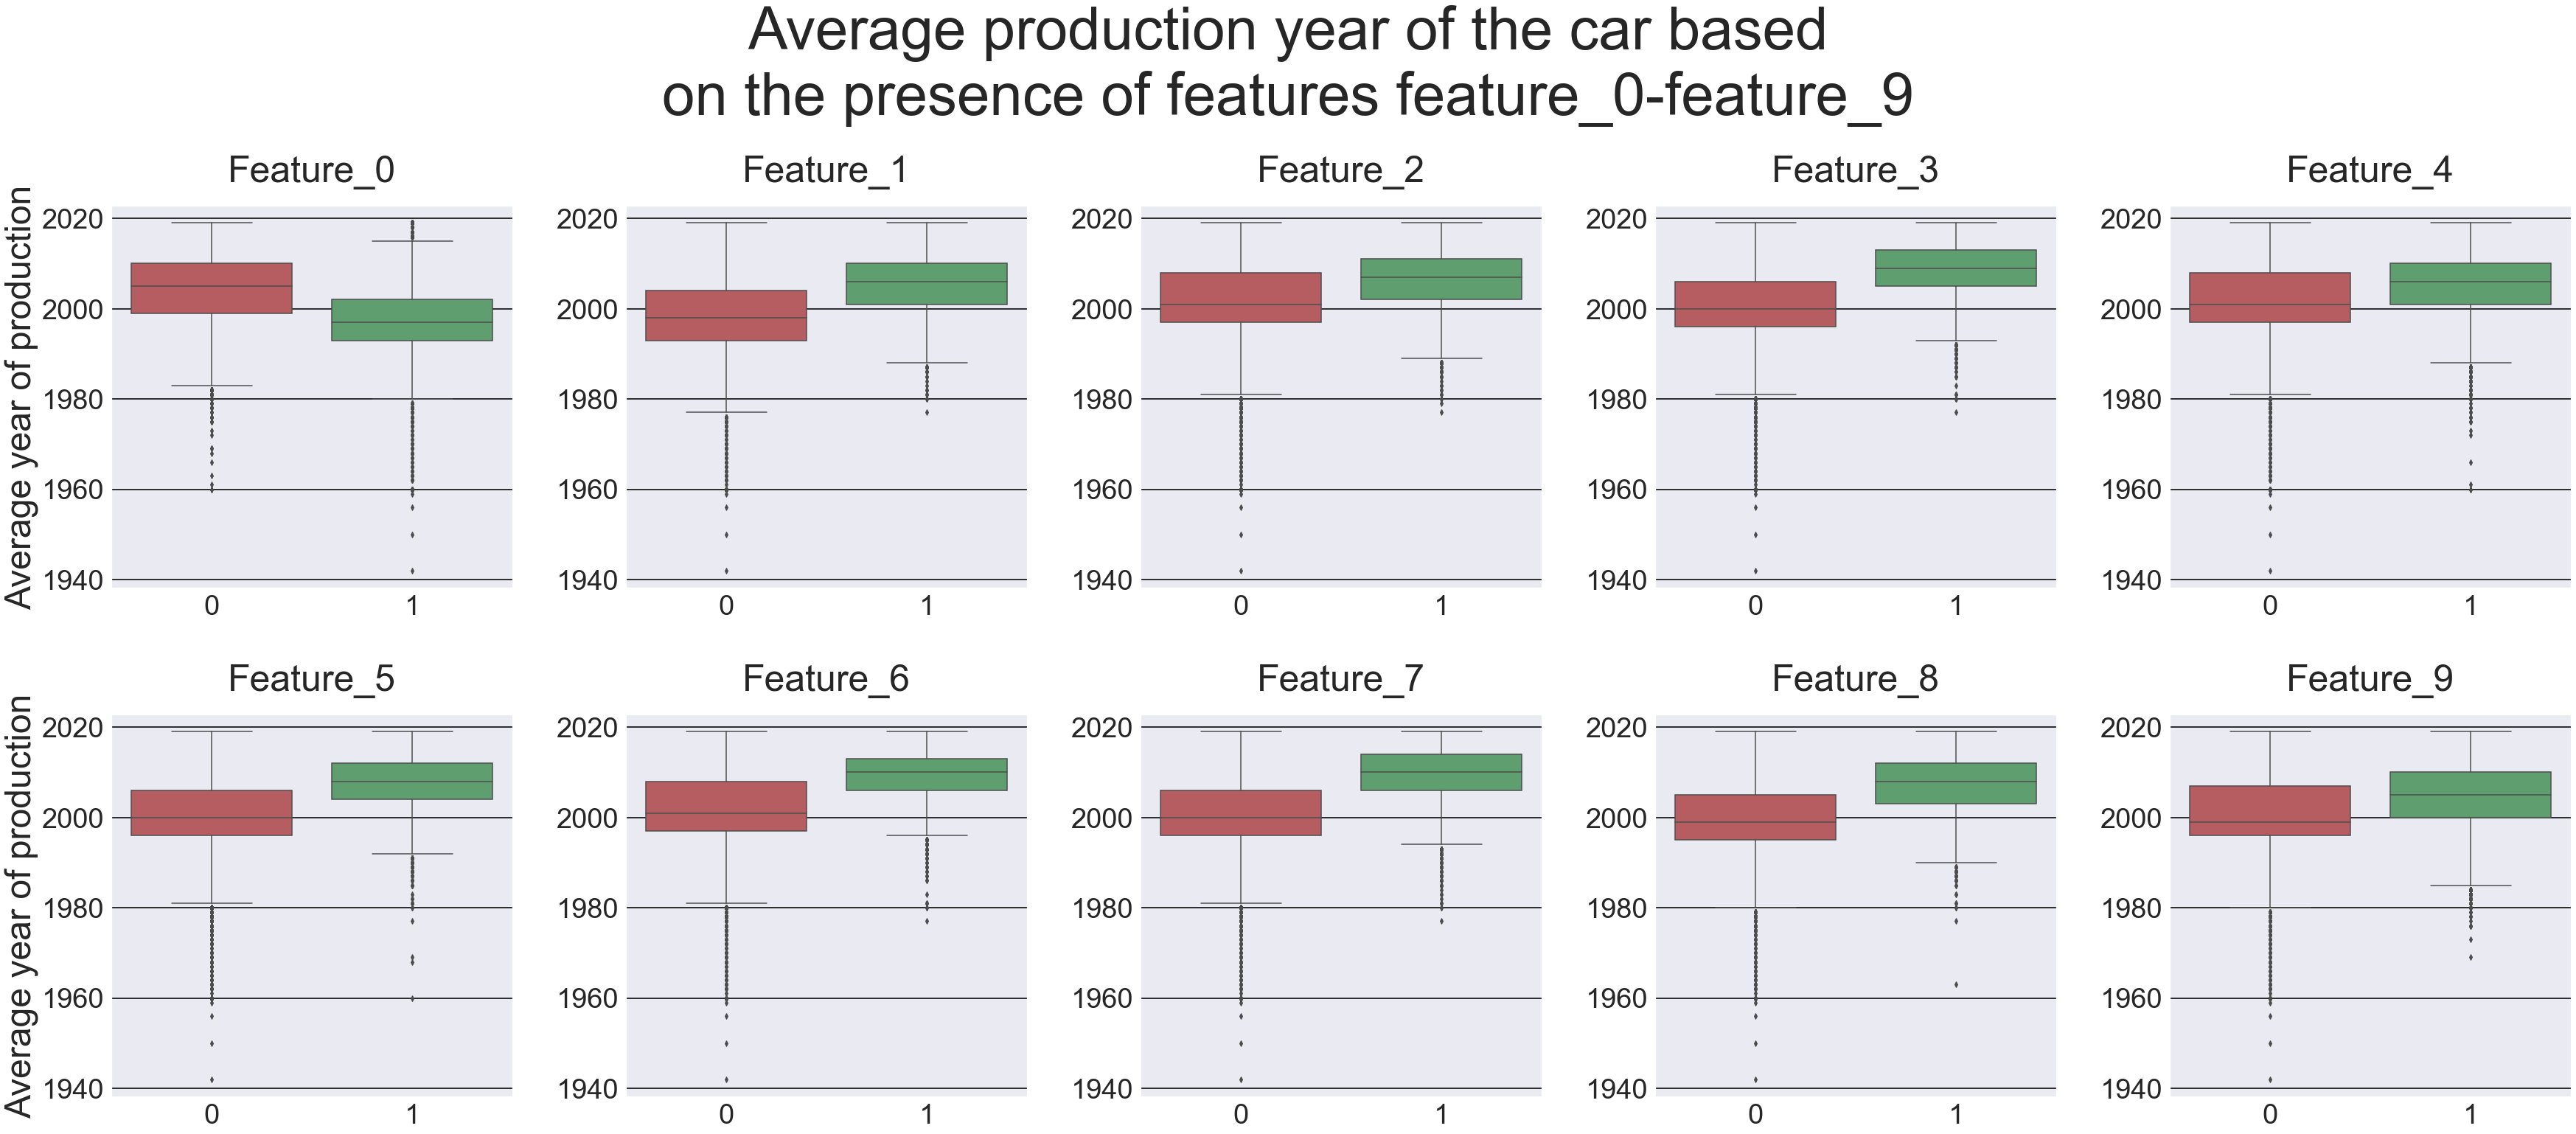

In [62]:
fig, axs = plt.subplots(2, 5, figsize=(50, 20))
fig.suptitle("Average production year of the car based\non the presence of features feature_0-feature_9", fontsize=80, y=1.1)

i = 0
for x in range(2):
    for y in range(5):
        feature = features[i]
        sb.boxplot(x=feature, y="year_produced", data=df,
                  ax=axs[x, y], palette=["r", "g"])
        axs[x, y].set_title(f"{feature}".capitalize(), size=50, pad=32)
        axs[x, y].set_xlabel("")
        axs[x, y].set_ylabel("Average year of production", fontsize=48)
        axs[x, y].tick_params(labelsize=38)
        axs[x, y].grid(which="both", axis="y", linewidth=1.8, color="k")
        if y:
            axs[x, y].set_ylabel("")
        i += 1

fig.tight_layout(pad=5)

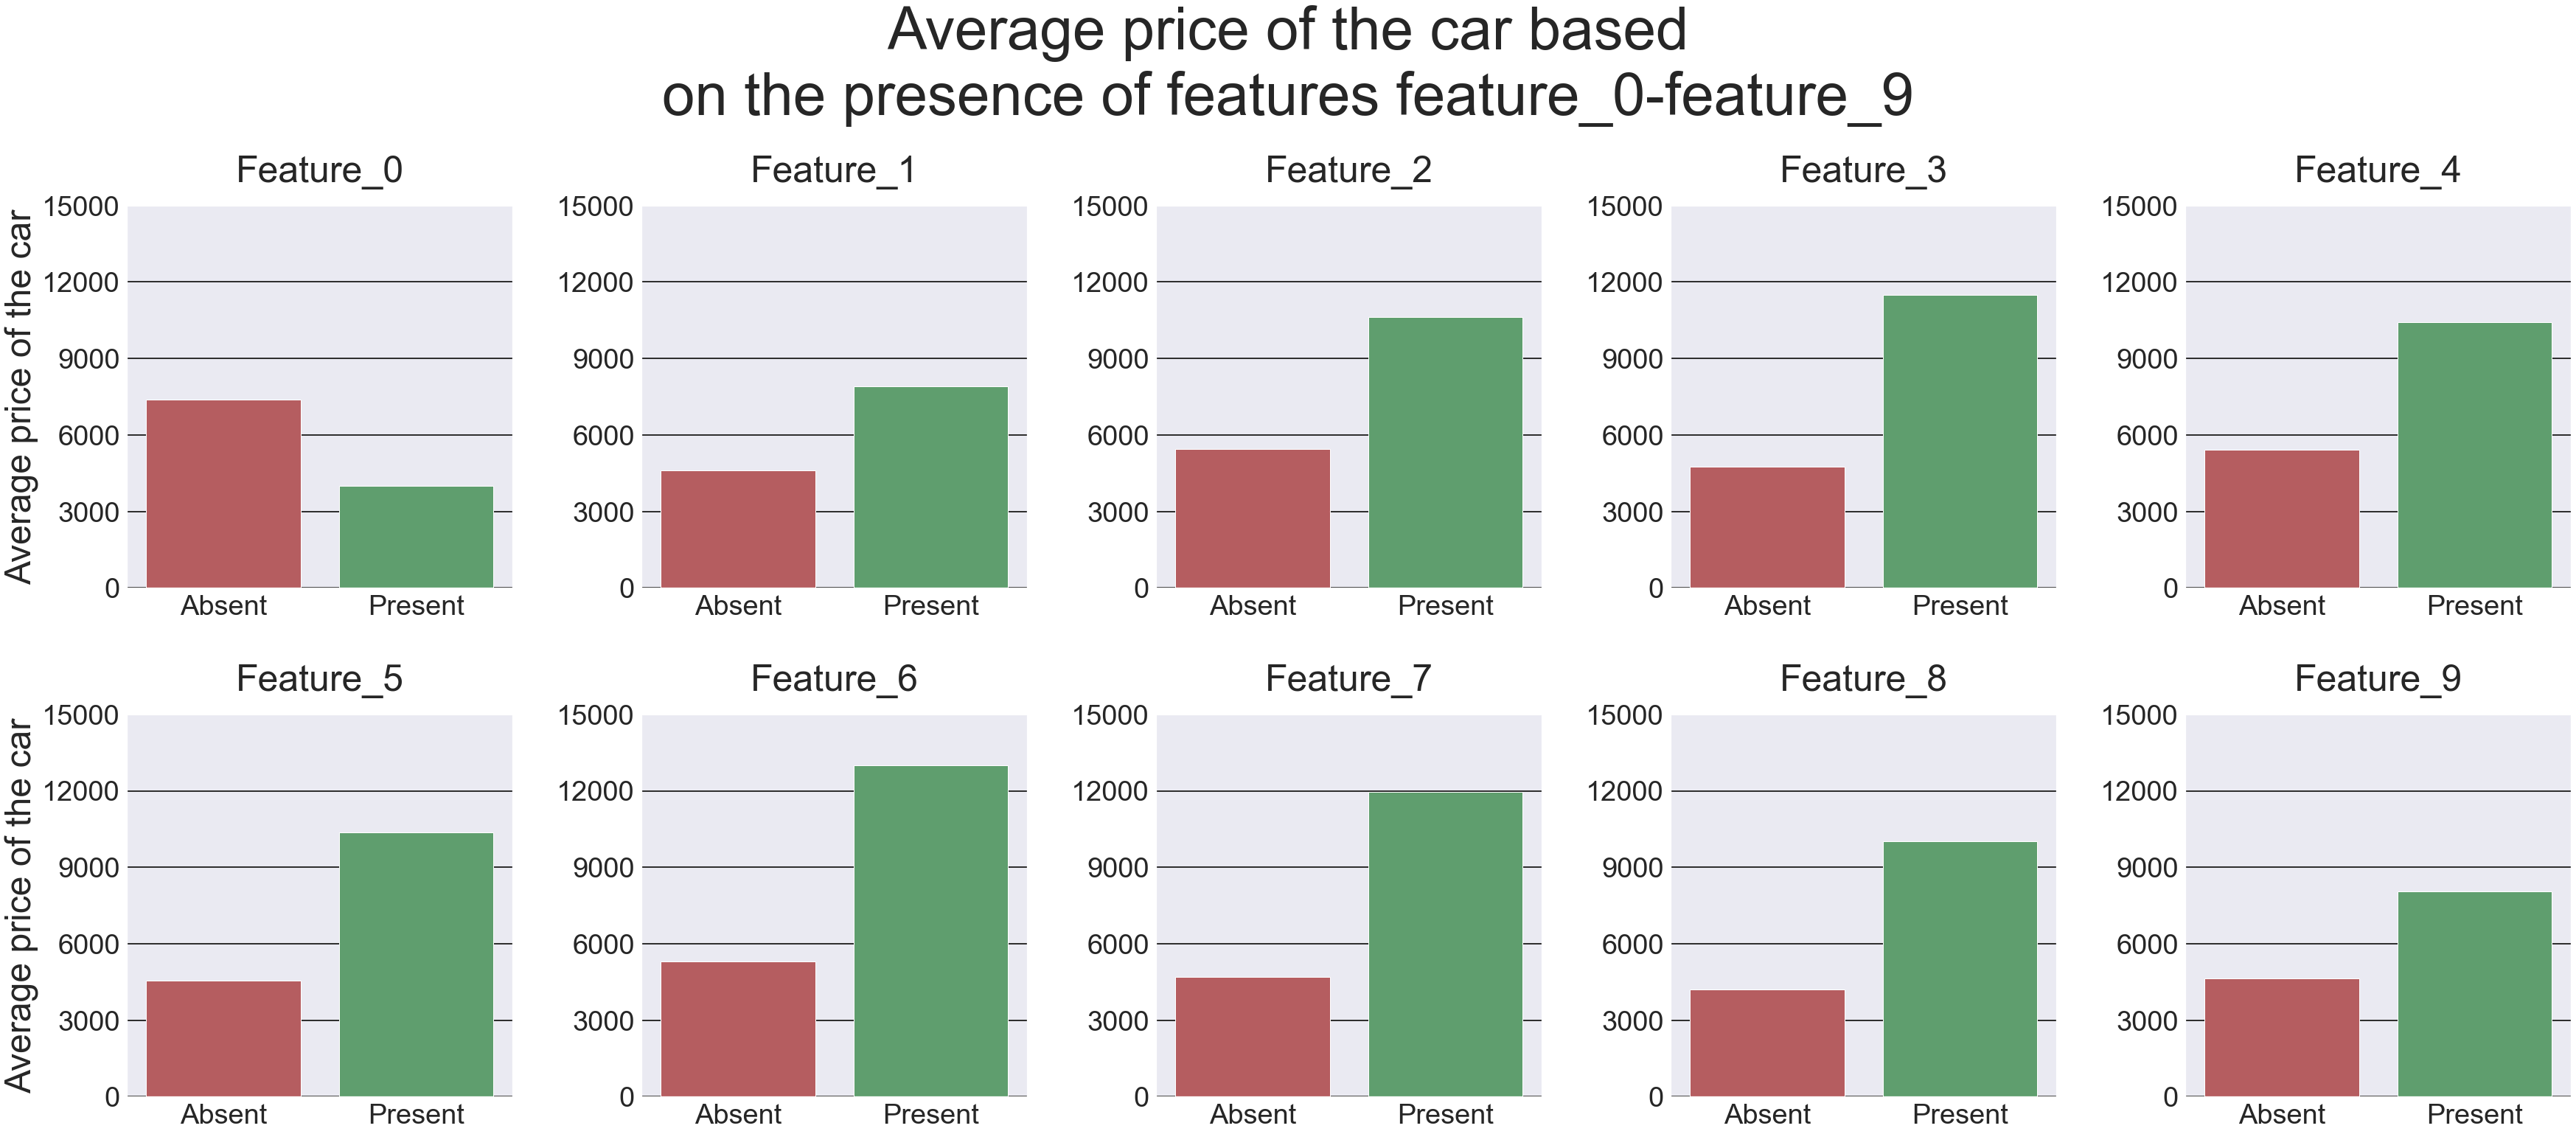

In [63]:
fig, axs = plt.subplots(2, 5, figsize=(50, 20))
fig.suptitle("Average price of the car based\non the presence of features feature_0-feature_9", fontsize=80, y=1.1)

i = 0
for x in range(2):
    for y in range(5):
        feature = features[i]
        sub_df = df.groupby([feature]).price_usd.agg(["mean"]).astype(int).rename({0: "Absent", 1: "Present"}).reset_index()
        sb.barplot(x=feature, y="mean", data=sub_df,
                  ax=axs[x, y], palette=["r", "g"])
        axs[x, y].set_title(f"{feature}".capitalize(), size=50, pad=32)
        axs[x, y].set_xlabel("")
        axs[x, y].set_ylabel("Average price of the car", fontsize=48)
        axs[x, y].set_yticks(range(0, 15001, 3000))
        axs[x, y].tick_params(labelsize=38)
        axs[x, y].grid(which="both", axis="y", linewidth=1.8, color="k")
        if y:
            axs[x, y].set_ylabel("")
        i += 1

fig.tight_layout(pad=5)

In [64]:
B = "\033[1m"
B_end = "\033[0m"

d1 = {}
d2 = {}
for feature in features:
    d1[feature] = ("", 0, 0)
    d2[feature] = ("", 100, 0)

for body in df["body_type"].unique():
    l = len(df[df["body_type"] == body])
    for feature in features:
        lf = len(df[(df["body_type"] == body) & (df[feature] == 1)])
        r = lf/l
        if r > d1[feature][1]:
            d1[feature] = (body, r, lf)
        
        if r < d2[feature][1]:
            d2[feature] = (body, r, lf)

for feature in features:
    print(f"The most likely car type to contain " + B+f"{feature}"+B_end + " is " + B+f"{d1[feature][0]}"+B_end +
          " in " + B+f"{round(d1[feature][1]*100)} %"+B_end + f" of all {d1[feature][0]}s, which is " + 
          B+f"{d1[feature][2]}"+B_end + " cars")
    
print()
for feature in features:
    print(f"The least likely car type to contain " + B+f"{feature}"+B_end + " is " + B+f"{d2[feature][0]}"+B_end +
          " in " + B+f"{round(d2[feature][1]*100)} %"+B_end + f" of all {d2[feature][0]}s, which is " + 
          B+f"{d2[feature][2]}"+B_end + " cars")
        

The most likely car type to contain feature_0 is van in 71 % of all vans, which is 558 cars
The most likely car type to contain feature_1 is limousine in 82 % of all limousines, which is 9 cars
The most likely car type to contain feature_2 is cabriolet in 49 % of all cabriolets, which is 33 cars
The most likely car type to contain feature_3 is limousine in 64 % of all limousines, which is 7 cars
The most likely car type to contain feature_4 is limousine in 100 % of all limousines, which is 11 cars
The most likely car type to contain feature_5 is suv in 69 % of all suvs, which is 3481 cars
The most likely car type to contain feature_6 is suv in 37 % of all suvs, which is 1876 cars
The most likely car type to contain feature_7 is limousine in 55 % of all limousines, which is 6 cars
The most likely car type to contain feature_8 is suv in 70 % of all suvs, which is 3525 cars
The most likely car type to contain feature_9 is suv in 83 % of all suvs, which is 4217 cars

The least likely car t

<h2> Correlation Inspection </h2>

In [65]:
# In order to be able to inspect correlation and to prevent overfitting, 
# model name variable had to be cleaned
    # We have decided to group every entry present less than 10 times (inclusive) as "Other"
    # This resulted in smoothing the data by 613 unique model name values
    
to_group = df["model_name"].value_counts()
to_group = to_group[to_group < 11]
for name in to_group.index:
    df["model_name"].replace({name: "Other"}, inplace=True)

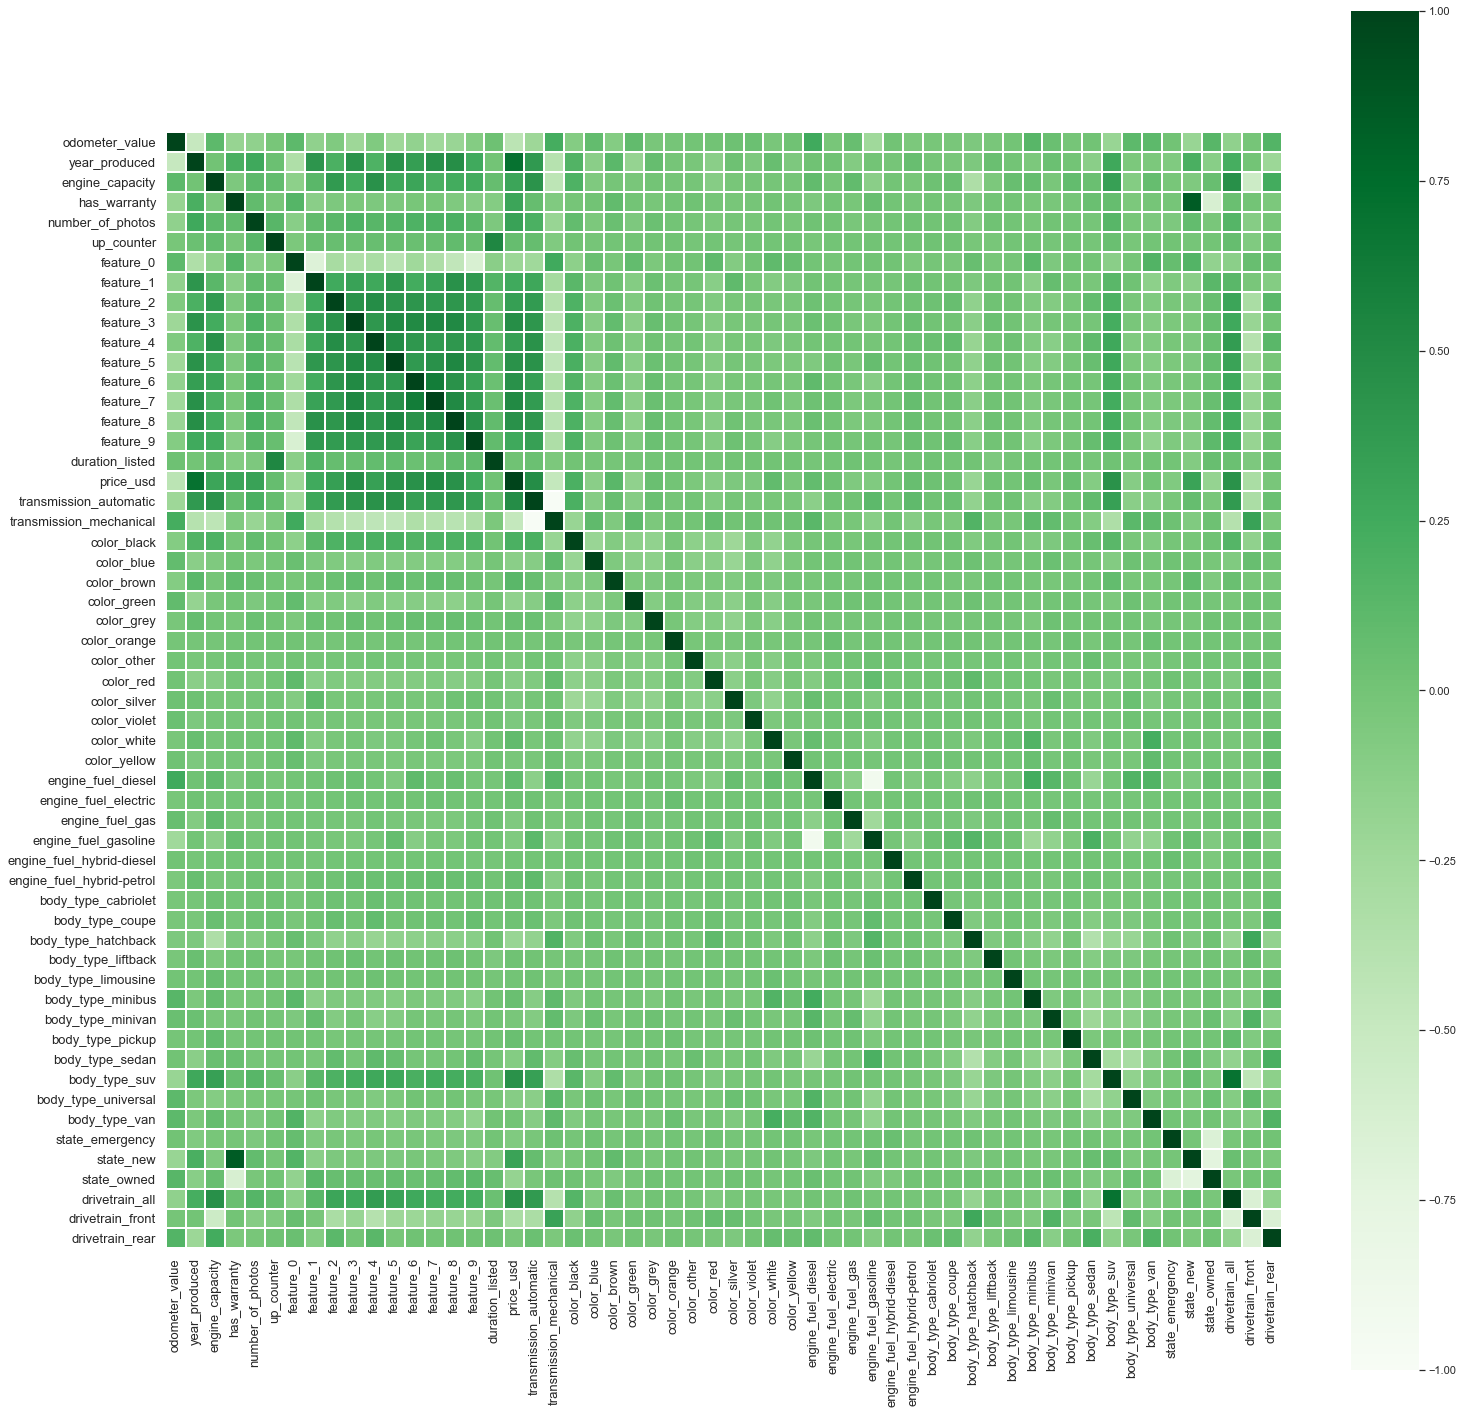

In [66]:
sub_df = df.copy()
sub_df = pd.get_dummies(data=sub_df, 
                       columns=["transmission", "color", "engine_fuel", 
                                "body_type", "state", "drivetrain"])

plt.figure(figsize=(25, 25))

sb.heatmap(sub_df.corr().round(2), vmin=-1, vmax=1,
          square=True, cmap="Greens", linewidths=1)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

In [67]:
# Some takeaways visible even from such messy chart:

    # Features feature_1-feature_9 are quite strongly correlated to each other 
    # and inversely correlated to feature_0
    # Same goes for correlation of these features with the year of production & price
        # We have basically discovered these relations earlier
    
    # One could say state "new" is almost equal to positive has_warranty column
    
    # SUV bodytype is strongly correlated to "all" drivetrain type
    # and SUV + all drivetrain type are both quite correlated with the features 1-9

In [68]:
# We can see that these two columns are not entirely equal and therefore both will remain in the dataset

print(len(df[(df["state"] == "new") & (df["has_warranty"] == False)]))
print(len(df[(df["state"] != "new") & (df["has_warranty"] == True)]))

53
73


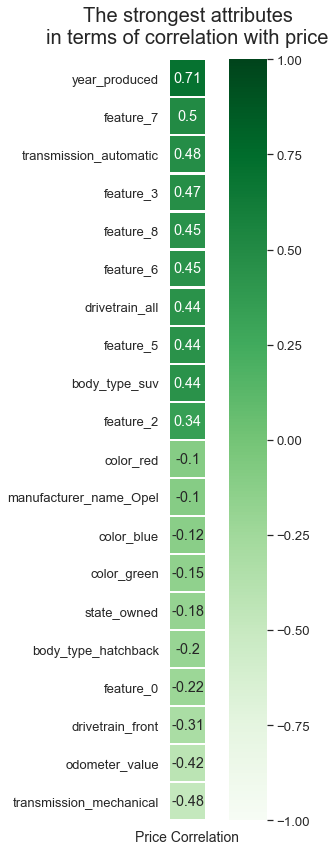

In [69]:
sub_df = df.copy()
sub_df = pd.get_dummies(sub_df)
sub_df_corr = sub_df.corr().round(2)
price_corr = pd.DataFrame(sub_df_corr[abs(sub_df_corr["price_usd"]) > 0.05
                                     ].drop(["price_usd"], axis=0)["price_usd"].sort_values(ascending=False))
price_corr.rename(columns={"price_usd": "Price Correlation"}, inplace=True)

plt.figure(figsize=(8, 14))
sb.set(font_scale=1.2)

sb.heatmap(pd.concat([price_corr.head(10), price_corr.tail(10)]), vmin=-1, vmax=1,
          square=True, cmap="Greens", annot=True, linewidths=1.2)

plt.title("The strongest attributes\nin terms of correlation with price", fontsize=20, pad=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=13)


plt.show()

<h2>Model building</h2>

In [70]:
df_copy = df.copy()

<h3>Linear regression</h3>

In [72]:
# First of all, we need to make sure that 
# all the key linear regression assumptions are valid

# Let us start with the ones we can check before we build the model

In [73]:
# 1. Linear relationship of dependent variable with independent ones

continuous = ["odometer_value", "year_produced", "engine_capacity", 
              "number_of_photos", "up_counter", "duration_listed"]

fig, axs = plt.subplots(2, 3, figsize=(24, 16))
fig.suptitle("Relationship between the continuous variables and price", fontsize=42, y=1.03)

i = 0
for x in range(2):
    for y in range(3):
        feature = continuous[i]
        sb.scatterplot(data=df.sample(500), x=feature, y="price_usd", ax=axs[x, y])
        axs[x, y].set_title(f"{feature}", size=34, pad=28)
        axs[x, y].set_xlabel("")
        axs[x, y].set_ylabel("Price", fontsize=40)
        axs[x, y].set_yticks(range(0, 50001, 5000))
        axs[x, y].tick_params(labelsize=22)
        axs[x, y].grid(which="both", axis="y", linewidth=1.6, color="k")
        if y:
            axs[x, y].set_ylabel("")
        i += 1

fig.tight_layout(pad=2)

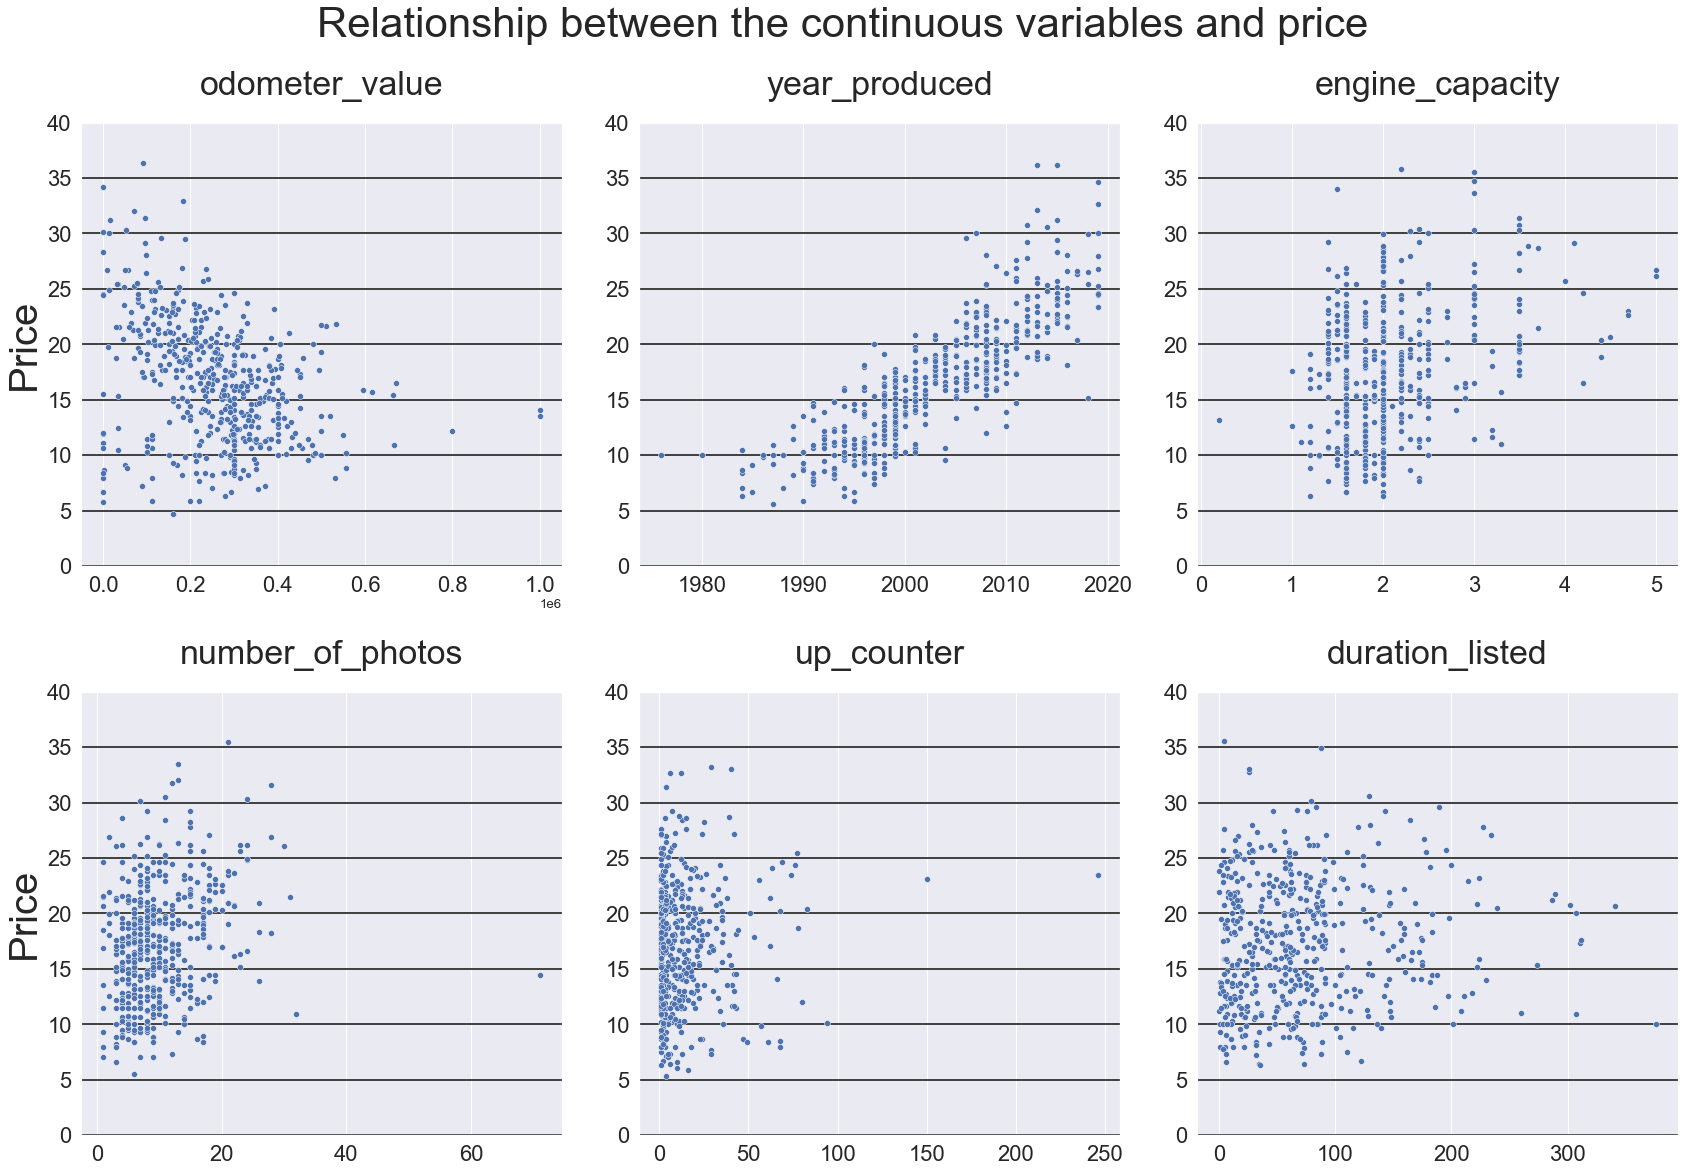

In [74]:
# We can transform the odometer value and year produced relationships with price
# to be linear by taking a cube root of the price
# Other continuous variables show signs of no polynomial relationship with price
# which is an additional argument for dropping them in case we would find out
# their insignificance

df["price_usd"] = df["price_usd"].apply(lambda x: x**(1/3))

continuous = ["odometer_value", "year_produced", "engine_capacity", 
              "number_of_photos", "up_counter", "duration_listed"]

fig, axs = plt.subplots(2, 3, figsize=(24, 16))
fig.suptitle("Relationship between the continuous variables and price", fontsize=42, y=1.03)

i = 0
for x in range(2):
    for y in range(3):
        feature = continuous[i]
        sb.scatterplot(data=df.sample(500), x=feature, y="price_usd", ax=axs[x, y])
        axs[x, y].set_title(f"{feature}", size=34, pad=28)
        axs[x, y].set_xlabel("")
        axs[x, y].set_ylabel("Price", fontsize=40)
        axs[x, y].set_yticks(range(0, 41, 5))
        axs[x, y].tick_params(labelsize=22)
        axs[x, y].grid(which="both", axis="y", linewidth=1.6, color="k")
        if y:
            axs[x, y].set_ylabel("")
        i += 1

fig.tight_layout(pad=2)

In [75]:
# 2. Multicorrelation of independent variables

df = pd.get_dummies(df, drop_first=True)
df_corr = df.drop(columns="price_usd").corr().abs().unstack()

cols = df.drop(columns="price_usd").columns
df_corr.drop(labels=[(cols[i], cols[j]) for i in range(0, len(cols)) for j in range(0, i+1)], inplace=True)

df_corr[df_corr >= 0.8]

has_warranty               state_new                    0.854713
manufacturer_name_Buick    model_name_Encore            0.932431
manufacturer_name_Iveco    model_name_Daily             1.000000
manufacturer_name_Jeep     model_name_Grand Cherokee    0.822311
manufacturer_name_Porsche  model_name_Cayenne           0.920465
dtype: float64

In [76]:
# Correlation of independent variables of 0.8 and more is too much
    # We can definitely drop model_name_Daily with a correlation of 1
        # This means that all Iveco cars are a model Daily
    
    # We have made an educated decision to also drop other model names
    # as manufacturer name holds more information
    
    # We have decided that state_new preserves more information
    # than has_warranty, and therefore has_warranty will be the column to be dropped
    
df.drop(columns=["has_warranty", "model_name_Encore", "model_name_Daily",
                "model_name_Grand Cherokee", "model_name_Cayenne"], inplace=True)

In [77]:
# To check other assumptions, we first need to build the model

In [78]:
X = df.drop(columns="price_usd")
y = df["price_usd"]

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=10)

In [79]:
lir = LinearRegression(n_jobs=-1)
lir.fit(train_X, train_y)
lir_preds = lir.predict(val_X)

In [80]:
residuals = val_y - lir_preds

In [81]:
# 3. Normal distribution of residuals with mean 0

print(np.mean(residuals))

sb.histplot(data=residuals, binwidth=0.2)

plt.show()

0.011639462668010353


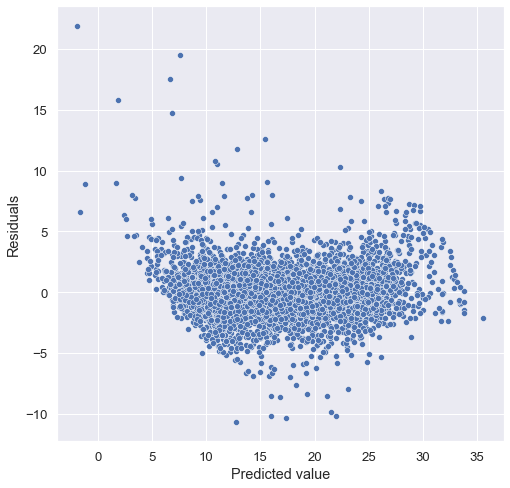

In [82]:
# 4. Homoscedasticity

# We can see that our predictions/residuals are quite homoscedastic 
# and therefore no special action is necessary

plt.figure(figsize=(8, 8))
sb.scatterplot(x=lir_preds, y=residuals)

plt.xlabel("Predicted value")
plt.ylabel("Residuals")

plt.show()

In [83]:
# There is no need to check for autocorrelation since 
# there is no time series data and the entries in the dataset are by nature mostly independent

In [84]:
# After making sure all the assumptions of Linear regression are met,
# we can now evaluate our model and start feature selection

# To achieve higher explainability, we will reverse 
# the cube root transformation made on the dependent variable

lir_preds = np.around(lir_preds**3)
val_y = val_y**3

def adjusted_r2(val, pred, k):
    r2 = r2_score(val, pred)
    n = len(val)
    return 1 - ((1 - r2)*(n-1))/(n-k-1)

print(f"Linear Regression R squared: {r2_score(val_y, lir_preds)} and adjusted R squared: {adjusted_r2(val_y, lir_preds, X.shape[1])}")
print("Linear Regression MAE:", mean_absolute_error(val_y, lir_preds))
print("Linear Regression RMSE:", (mean_squared_error(val_y, lir_preds))*(1/2))

Linear Regression R squared: 0.8751215108398305 and adjusted R squared: 0.8645288997581568
Linear Regression MAE: 1199.5751338167427
Linear Regression RMSE: 2619826.7833066327


In [85]:
# Since there are some huge outliers in terms of residuals, 
# RMSE is very high

# We can see how much these outliers contributed and also what individual entries they were below

In [86]:
res_outliers = residuals[np.abs(residuals-residuals.mean()) >= (5*residuals.std())].sort_values(ascending=False)
res_outliers

3402     21.869648
31542    19.521899
27080    17.546024
8459     15.763095
4532     14.724538
26552    12.593967
24778    11.794967
24770    10.749699
23451    10.572188
10054    10.324038
8431      9.415495
34220     9.085943
23315     8.968513
8344      8.953071
378       8.857932
23383    -9.823797
4483    -10.132419
23463   -10.164531
23328   -10.298853
27570   -10.625526
Name: price_usd, dtype: float64

In [87]:
df_copy.iloc[res_outliers.index]

manufacturer_name model_name transmission   color  odometer_value  \
3441               Opel      Astra   mechanical   black           70000   
32032             Skoda    Octavia   mechanical   black               0   
27505               BMW        318   mechanical  violet          265000   
8584                ВАЗ       2106   mechanical     red          100000   
4586         Alfa Romeo        146   mechanical  silver          300000   
26967            Nissan    X-Trail   mechanical    grey          303000   
25167           Hyundai    Solaris   mechanical  silver           96000   
25159           Hyundai    Elantra    automatic  silver          180000   
23810             Volvo       XC60    automatic   brown          141256   
10204              Ford    Scorpio   mechanical    grey         1000000   
8556                ВАЗ       2105   mechanical   other           34837   
34760     Mercedes-Benz       Vito   mechanical   white          320000   
23671             Volvo      Other   mechanical    blue          130000   
8469                ВАЗ       2101   mechanical     red           10000   
387                LADA     Largus   mechanical   white           99000   
23739             Volvo       XC60    automatic   black          209000   
4535         Alfa Romeo      Other   mechanical   other          235009   
23822             Volvo        S80    automatic   black          300000   
23684             Volvo        V50   mechanical   black          200000   
28001               BMW        530   mechanical  silver          400000   

       year_produced engine_fuel  engine_capacity  body_type  has_warranty  \
3441            2012    gasoline              1.4  hatchback             0   
32032           2019    gasoline              1.4      sedan             1   
27505           1996    gasoline              1.8      sedan             0   
8584            1990    gasoline              1.5  universal             0   
4586            1996    gasoline              1.6      sedan             0   
26967           2002      diesel              2.2        suv             0   
25167           2015    gasoline              1.4      sedan             0   
25159           2008    gasoline              1.6      sedan             0   
23810           2010      diesel              2.4        suv             0   
10204           1988    gasoline              2.9  hatchback             0   
8556            2005    gasoline              1.5      sedan             0   
34760           1999      diesel              2.2    minibus             0   
23671           2015      diesel              2.0  universal             0   
8469            1981    gasoline              1.3  hatchback             0   
387             2016    gasoline              1.6  universal             0   
23739           2010    gasoline              3.0        suv             0   
4535            1994      diesel              1.9      sedan             0   
23822           2001    gasoline              2.4      sedan             0   
23684           2006    gasoline              1.8  universal             0   
28001           2001    gasoline              3.0  universal             0   

       state drivetrain location_region  number_of_photos  up_counter  \
3441   owned      front     Гродненская                 7           1   
32032    new      front         Минская                15          12   
27505  owned       rear         Минская                12          13   
8584   owned      front      Гомельская                 3           1   
4586   owned      front         Минская                 7           1   
26967  owned        all         Минская                 2           1   
25167  owned      front      Гомельская                 7           4   
25159  owned      front         Минская                12          99   
23810  owned      front         Минская                19          16   
10204  owned       rear       Брестская                21    

In [88]:
# Based on the analysis of outliers, we have not been able 
# to find any that would seem like error entries

# However, we have come to a theory that these entries confuse our model as 
# it values the year_produced column a lot (due to high correlation) and
# these entries usually have these 2 attributes inversely proportional
    # This may be explained for instance by these cars being valuable veteran cars

In [89]:
# Permutation importance analysis has not brought any relevant view on the features

In [90]:
# Our model seems to not value some columns which are strongly correlated with price
# Therefore, we cannot simply drop features with low coefficient

coefs = {}

for ind, col in enumerate(X.columns):
    coefs[col] = lir.coef_[ind]
    
coefs = dict(sorted(coefs.items(), key=lambda x: x[1], reverse=True))
coefs

{'model_name_21': 10.749042144783235,
 'model_name_69': 8.439120378539961,
 'model_name_Kodiaq': 7.130996425659365,
 'model_name_2101': 6.7781810739563175,
 'state_new': 6.688623901420416,
 'model_name_24': 6.278990783987335,
 'model_name_Master': 5.856048280459566,
 'model_name_Land Cruiser': 5.5222539819998495,
 'model_name_Superb': 5.304552679619953,
 'model_name_Alhambra': 5.184019793671672,
 'model_name_Trafic': 5.0725697810509365,
 'model_name_T4 Multivan': 4.898294944175258,
 'model_name_T5 Multivan': 4.657948755396326,
 'manufacturer_name_Lexus': 4.50013864043746,
 'model_name_Octavia': 4.412118536119169,
 'model_name_Boxer': 4.350839051619161,
 'manufacturer_name_Land Rover': 4.194668122036634,
 'model_name_Vivaro': 4.056886981594279,
 'model_name_T4 Caravelle': 3.9866312103806654,
 'manufacturer_name_Москвич': 3.909405772351893,
 'model_name_T5 Caravelle': 3.8710676005647153,
 'model_name_469': 3.805789379239605,
 'model_name_Grand Espace': 3.7459538096983493,
 'model_name_Hi

In [91]:
# We have tried dropping some of the least price correlated features
# However, this only resulted in little negative change in the R squared scores of the model

In [92]:
# The same goes for dropping some of the features with no linear relations to price
# Those are namely engine capacity, number of photos, up counter and duration listed 

<h3>Statsmodels Linear Regression</h3>

In [93]:
X_sm = X = sm.add_constant(X)
model = sm.OLS(y, X_sm).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_usd   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     611.9
Date:                Tue, 13 Jul 2021   Prob (F-statistic):               0.00
Time:                        20:51:16   Log-Likelihood:                -73543.
No. Observations:               37924   AIC:                         1.483e+05
Df Residuals:                   37330   BIC:                         1.533e+05
Df Model:                         593                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            -906.1351      4.440   -204.094      0.000    -914.837    -897.433
odometer_value                  -3.029e-06   8.46e-08    -35.801      0.000   -3.19e-06   -2.86e-06
year_produced                       0.4611      0.002    208.921      0.000       0.457       0.465
engine_capacity                     0.3371      0.027     12.395      0.000       0.284       0.390
number_of_photos                    0.0385      0.002     24.735      0.000       0.035       0.042
up_counter                         -0.0023      0.000     -5.085      0.000      -0.003      -0.001
feature_0                          -0.2340      0.035     -6.659      0.000      -0.303      -0.165
feature_1                          -0.0003      0.027     -0.010      0.992      -0.053       0.052
feature_2                           0.1035      0.028      3.741      0.000       0.049       0.158
feature_3                           0.3215      0.027     11.761      0.000       0.268       0.375
feature_4                           0.1154      0.029      3.992      0.000       0.059       0.172
feature_5                           0.1139      0.026      4.306      0.000       0.062       0.166
feature_6                           0.2872      0.033      8.796      0.000       0.223       0.351
feature_7                           0.4687      0.029     16.229      0.000       0.412       0.525
feature_8                           0.0752      0.026      2.927      0.003       0.025       0.126
feature_9                           0.1498      0.026      5.789      0.000       0.099       0.201
duration_listed                     0.0017      0.000     10.290      0.000       0.001       0.002
manufacturer_name_Alfa Romeo       -2.2723      0.431     -5.273      0.000      -3.117      -1.428
manufacturer_name_Audi              1.3162      0.353      3.730      0.000       0.624       2.008
manufacturer_name_BMW               1.3496      0.337      4.002      0.000       0.689       2.011
manufacturer_name_Buick            -2.0457      0.427     -4.786      0.000      -2.883      -1.208
manufacturer_name_Cadillac         -1.4680      0.444     -3.305      0.001      -2.339      -0.597
manufacturer_name_Chery            -7.3643      0.428    -17.199      0.000      -8.204      -6.525
manufacturer_name_Chevrolet        -0.9733      0.361     -2.700      0.007      -1.680      -0.267
manufacturer_name_Chrysler         -1.3367      0.401     -3.336      0.001      -2.122      -0.551
manufacturer_name_Citroen          -2.1502      0.389     -5.526      0.000      -2.913      -1.387
manufacturer_name_Dacia            -3.3730      0.433     -7.789      0.000      -4.222      -2.524
manufacturer_name_Daewoo           -1.8949      0.442     -4.285      0.000      -2

In [96]:
# This functions allows us to simplify our model by dropping unnecessary features,
# meaning those with p value > given alpha
# The loop is stopped either by reducing r squared under given threshold (= not worth simplification),
# reaching the given number of features left or when there are no more features to be dropped
# (i.e. no features with p value higher than alpha)

def simplify(modelname, r2, num_features, X, y, alpha=0.01, add_const=False):
    if add_const:
        X_sm = X = sm.add_constant(X)
    else:
        X_sm = X
        
    to_drop = []
    r20 = modelname.rsquared
    while(modelname.rsquared > r2 and modelname.df_model > num_features):
        l = len(to_drop)
        X2 = X_sm.drop(columns=to_drop)
        modelname = sm.OLS(y, X2).fit()
        for feature, pvalue in modelname.pvalues.iteritems():
            if pvalue > alpha:
                to_drop.append(feature)
        if len(to_drop) == l:
            break

    print(f"Your model has been simplified by dropping {l} features at the cost of {round(r20-modelname.rsquared, 5)} R squared")
    return modelname.summary()

simplify(model, 0.9, 20, X_sm, y)

Your model has been simplified by dropping 252 features at the cost of 0.00273 R squared


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_usd   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     1038.
Date:                Tue, 13 Jul 2021   Prob (F-statistic):               0.00
Time:                        20:53:16   Log-Likelihood:                -74091.
No. Observations:               37924   AIC:                         1.489e+05
Df Residuals:                   37582   BIC:                         1.518e+05
Df Model:                         341                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            -908.9662      4.022   -225.990      0.000    -916.850    -901.083
odometer_value                  -3.054e-06   8.46e-08    -36.097      0.000   -3.22e-06   -2.89e-06
year_produced                       0.4624      0.002    231.189      0.000       0.459       0.466
engine_capacity                     0.3866      0.023     16.580      0.000       0.341       0.432
number_of_photos                    0.0391      0.002     24.964      0.000       0.036       0.042
up_counter                         -0.0022      0.000     -4.803      0.000      -0.003      -0.001
feature_0                          -0.2284      0.031     -7.457      0.000      -0.288      -0.168
feature_2                           0.1099      0.028      3.983      0.000       0.056       0.164
feature_3                           0.3249      0.027     11.895      0.000       0.271       0.378
feature_4                           0.1196      0.029      4.182      0.000       0.064       0.176
feature_5                           0.1304      0.026      4.978      0.000       0.079       0.182
feature_6                           0.2936      0.033      9.002      0.000       0.230       0.357
feature_7                           0.4528      0.029     15.690      0.000       0.396       0.509
feature_8                           0.0820      0.026      3.201      0.001       0.032       0.132
feature_9                           0.1713      0.026      6.653      0.000       0.121       0.222
duration_listed                     0.0016      0.000      9.835      0.000       0.001       0.002
manufacturer_name_Alfa Romeo       -1.8613      0.138    -13.457      0.000      -2.132      -1.590
manufacturer_name_Audi              1.5178      0.065     23.219      0.000       1.390       1.646
manufacturer_name_BMW               1.3604      0.068     19.988      0.000       1.227       1.494
manufacturer_name_Buick            -1.7973      0.257     -7.002      0.000      -2.300      -1.294
manufacturer_name_Cadillac         -1.4024      0.329     -4.265      0.000      -2.047      -0.758
manufacturer_name_Chery            -7.0150      0.304    -23.103      0.000      -7.610      -6.420
manufacturer_name_Chevrolet        -0.8673      0.133     -6.546      0.000      -1.127      -0.608
manufacturer_name_Chrysler         -0.8036      0.122     -6.603      0.000      -1.042      -0.565
manufacturer_name_Citroen          -1.9129      0.073    -26.223      0.000      -2.056      -1.770
manufacturer_name_Dacia            -3.2222      0.228    -14.149      0.000      -3.669      -2.776
manufacturer_name_Daewoo           -1.7077      0.317     -5.380      0.000      -2.330      -1.086
manufacturer_name_Fiat             -2.8110      0.077    -36.309      0.000      -2

<h3>Histogram Gradient Boosting</h3>

In [100]:
train_y = train_y**3

est = HistGradientBoostingRegressor()
est.fit(train_X, train_y)
est_preds = est.predict(val_X)

print(f"Histogram Gradient Booster R squared: {r2_score(val_y, est_preds)} and adjusted R squared: {adjusted_r2(val_y, est_preds, X.shape[1])}")
print("Histogram Gradient Booster MAE:", mean_absolute_error(val_y, est_preds))
print("Histogram Gradient Booster RMSE:", (mean_squared_error(val_y, est_preds))*(1/2))

Histogram Gradient Booster R squared: 0.9267568791427752 and adjusted R squared: 0.920532785610702
Histogram Gradient Booster MAE: 1055.2060334328028
Histogram Gradient Booster RMSE: 1536567.9950580662


<h2>Possible next steps</h2>

    • Dive more deeply into feature selection and hypertune the parameters of our model(s)
    • Scrape additional data about the cars from the internet - horsepower, trunk capacity, max speed, etc.
    • Analyse which cars could be considered "veterans" and might therefore be of higher price despite being old
        • This may have a strong positive impact on our models as these semmed to be the biggest outliers in terms of RMSE
    • Create a user interface where the user would input their car and the features of it and according to similar entries 
    a price would be estimated for it
        • For this purpose, we would need to know what are the features feature_0 - feature_9